# Purchase Prediction using a LSTM RNN

# Background 

This notebook was published as part of an <a href="https://aws.amazon.com/blogs/machine-learning/amazon-pinpoint-campaigns-driven-by-machine-learning-on-amazon-sagemaker/"> AWS ML blog </a>. It is the second notebook of two published as part of the blog. The <a href="https://github.com/aws-samples/aws-sagemaker-ml-blog-predictive-campaigns/blob/master/notebooks/Retail%2BData%2BDiscovery%2Band%2BProcessing%2Bv1.0.ipynb"> first notebook </a> presents the bulk of the data discovery and processing steps described in the blog. This second notebook takes the dataset generated by the first notebook, and demonstrates the training and model serving steps involved in a ML process to deploy a custom Tensorflow model in SageMaker. 

Read the blog for context around the use case.

The dataset referenced by this notebook originates from the public UCI Machine Learning Repository: http://archive.ics.uci.edu/ml/datasets/online+retail

<b> Source: </b>

Dr Daqing Chen, Director: Public Analytics group. chend '@' lsbu.ac.uk, School of Engineering, London South Bank University, London SE1 0AA, UK.

<b> Data Set Information: </b>

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

<b> Attribute Information: </b>

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. Description: Product (item) name. Nominal. Quantity: The quantities of each product (item) per transaction. Numeric.
InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. UnitPrice: Unit price. Numeric, Product price per unit in sterling. CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. Country: Country name. Nominal, the name of the country where each customer resides.

# Setup

This notebook was created and tested on an <i> ml.p2.xlarge </i> notebook instance running the <i> conda_tensorflow_p27 kernel </i>. The p-class instance was selected for local GPU training, which was ideal for rapid prototyping. However, a <i> ml.m4.xlarge </i> instance is more than sufficient to run this notebook.

Begin by...
1. Follow the instructions in the first notebook <TODO LINK>. The notebook will produce two files used by this notebook. 
2. Start up a notebook instance, and ensure the instance has accessed to the files produced by the first notebook

Check the devices available on your notebook. If you provisoned a p type instance, you should see a GPU device like <i> '/device:GPU:0' </i>

In [1]:
from tensorflow.python.client import device_lib

def get_available_devices():  
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())  

['/device:CPU:0', '/device:GPU:0']


Additional libarires need to be installed and updated on the notebook instance. For instance, you will need pandas 0.22+ as well as some other libraries to read the parquet file from S3. Run the following commands to install them on your instance

In [ ]:
!yes | conda update -n base conda
!yes | conda update pandas
!yes | conda update dask
!pip install s3fs
!pip install -U fastparquet
#!yes | conda install -c anaconda tensorflow-tensorboard 

Import the required dependencies

In [2]:
import boto3
import s3fs
import pandas as pd
import numpy as np
import os
from io import BytesIO, StringIO
import gzip

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Embedding, TimeDistributed
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.estimator.export.export_output import PredictOutput
from tensorflow.python.saved_model.signature_constants import DEFAULT_SERVING_SIGNATURE_DEF_KEY

from sagemaker.tensorflow import TensorFlow
from sagemaker.tensorflow.predictor import tf_serializer, tf_deserializer
from sagemaker.predictor import RealTimePredictor
from sagemaker.content_types import CONTENT_TYPE_OCTET_STREAM
from tensorflow_serving.apis import predict_pb2

pd.set_option("display.max_rows", 10)

Update S3_BUCKET with the name of the bucket containing the datasets that you created using the first notebook. Set S3_TARGET_PREFIX to the parquet file that contains our sparse vectors of customer orders. Ensure your notebook instance has access to the files in this bucket.

In [3]:
S3_BUCKET = "dtong-ml-datasets"
S3_TARGET_PREFIX = "/processed/ecomm/cart_sparse_vecs.parquet.gz"
S3_LOCATION = "s3://"+S3_BUCKET+S3_TARGET_PREFIX 
print(S3_LOCATION)

s3://dtong-ml-datasets/processed/ecomm/cart_sparse_vecs.parquet.gz


Load the file

In [4]:
carts = pd.read_parquet(S3_LOCATION, engine='fastparquet')
print("Dataset shape: "+str(carts.shape))
print("Sample: \n"+str(carts[0:1]))

Dataset shape: (10827, 4)
Sample: 
   CustomerID  InvoiceNo  InvoiceDate  \
0       18283     540350   1294323240   

                                                Cart  
0  [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, ...  


Next, we load the csv file, which contains the product lookup table. You should have created this file from the first notebook. Set S3_TARGET_PREFIX to the location of this file.

In [5]:
S3_TARGET_PREFIX = "/processed/ecomm/customer_basket_list.csv.gz"
S3_LOCATION = "s3://"+S3_BUCKET+S3_TARGET_PREFIX 
print(S3_LOCATION)

s3://dtong-ml-datasets/processed/ecomm/customer_basket_list.csv.gz


Load the file

In [6]:
products = pd.read_csv(S3_LOCATION, compression='gzip', header=None, sep=',', names=["Description","Index"])
nProducts = products.shape[0] 
nSequences = carts.shape[0]
nCustomers = len(carts.groupby("CustomerID").CustomerID)

print("Product lookup table shape: "+str(products.shape))
print("Number of customers: "+str(nCustomers))

Product lookup table shape: (3648, 2)
Number of customers: 1090


Convert the dataset to a pandas dataframe to fascilitate reshaping the dataset. The orders are stored in the "Cart" column as a list. The following unwind this list so that each index value is stored as a column in the dataframe. 

In [7]:
cartsDF = pd.merge(pd.DataFrame(carts[["CustomerID","InvoiceDate"]]), \
         pd.DataFrame(carts["Cart"].values.tolist(), dtype=np.float32), \
         how = "left", left_index = True, right_index = True)

display(cartsDF)

,CustomerID,InvoiceDate,0,1,2,3,4,5,6,7,...,3638,3639,3640,3641,3642,3643,3644,3645,3646,3647
0,18283,1294323240,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18283,1295794680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,18283,1298889000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18283,1303403820,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18283,1306150380,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10822,12347,1302172980,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10823,12347,1307624460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10824,12347,1312274880,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10825,12347,1320063900,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We need to reshape the dataframe into the following datasets so that it can be utilize by the LSTM model that we build in this notebook:

1. <b>X</b>: contains the inputs shaped as <total batches, time slices, number of products>. Conceptually, this data set is organized as a sequence of 49 orders for each of our customers. All customers have varying number of orders, so customers who have less than 50 orders have zero vectors serving as placeholders. 
2. <b>Y</b>: represents our targets. Essentially, they are the predictions for the next time step. Y is just X shifted by one time slice as we're trying to train a model that learns the next time slice.
3. <b>SL</b>: we use Tensorflow's dynamic RNN model. Normally RNNs require fixed sequence lengths, which is wasteful in many ways. <a href="https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn"> Dyanmic RNNs </a> provides a more efficient means of support variable sequence lengths. In order to use the dynamic rnn model, a vector of sequence lengths have to be provided to the Tensorflow model to support dynamic unrolling. 

In [8]:
MAX_TIMESTEPS = 50
adjustedSteps = MAX_TIMESTEPS - 1

cartsMat = cartsDF.as_matrix()
X = np.zeros((nCustomers,adjustedSteps,nProducts))
Y = np.zeros((nCustomers,adjustedSteps,nProducts))
SL = np.ones(nCustomers)

lastCustomer = cartsMat[0,0]
timeStep = 0
cIdx = 0

for i in range(nSequences-1) :
    
    cid = cartsMat[i,0]
    if (cid != lastCustomer) :                   
 
        if ((timeStep >= 1) and (timeStep <= adjustedSteps)) :
            Y[cIdx:cIdx+1,timeStep-1,:] = 0.
            X[cIdx:cIdx+1,timeStep-1,:] = 0.
            SL[cIdx] = timeStep-1
    
        timeStep = 0
        cIdx = cIdx + 1
        Y[cIdx:cIdx+1,timeStep,:] = cartsMat[i+1,2:]
        X[cIdx:cIdx+1,timeStep,:] = cartsMat[i,2:]
        timeStep = timeStep + 1  
        
    elif (timeStep < adjustedSteps) :
        
        Y[cIdx:cIdx+1,timeStep,:] = cartsMat[i+1,2:]
        X[cIdx:cIdx+1,timeStep,:] = cartsMat[i,2:]
        timeStep = timeStep + 1  
        SL[cIdx] = timeStep  
    
    elif (timeStep >= adjustedSteps) :
        timeStep = timeStep + 1 
        
    lastCustomer = cid 
    
print("X shape: "+ str(X.shape))
print("Y shape: "+ str(Y.shape))
print("Sequence Lengths shape: "+ str(SL.shape))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


X shape: (1090, 49, 3648)
Y shape: (1090, 49, 3648)
Sequence Lengths shape: (1090,)


We'll create a variation of the Y dataset, so that they better represent target softmax outputs. We'll normalize all the values of the Y vectors, so that the values in the vector represent probabilities. Each product purchase is assign equal probability.

In [9]:
Y_sm = np.divide(Y,np.maximum(1.,Y.sum(axis=2))[:,:,None])
print(Y_sm[0:2,0:2,0:10])

[[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.03448276 0.         0.         0.         0.         0.
   0.         0.         0.         0.03448276]]

 [[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.02702703 0.         0.        ]]]


We'll use a random 80:20 split on the dataset for training and validation

In [10]:
X = X.astype(np.float32)
Y = Y.astype(np.float32)
Y_sm = Y_sm.astype(np.float32)
SL = SL.astype(np.int32)

X, Y, Y_sm, SL = shuffle(X, Y, Y_sm, SL)
X_train, X_val, Y_train, Y_val, Y_sm_train, Y_sm_val, SL_train, SL_val = train_test_split(X, Y, Y_sm, SL, test_size=0.2)

print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)
print(SL_train.shape)
print(SL_val.shape)

(872, 49, 3648)
(218, 49, 3648)
(872, 49, 3648)
(218, 49, 3648)
(872,)
(218,)


Sagemaker training expects to obtain these datasets from an S3 location. We'll convert this dataset back into pandas dataframes to fasciltiate writing our training, validation and sequence length datasets out to S3.

In [11]:
X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0]*X_train.shape[1],X_train.shape[2]),dtype=np.float32)
Y_train_df = pd.DataFrame(Y_sm_train.reshape(Y_sm_train.shape[0]*Y_sm_train.shape[1],Y_sm_train.shape[2]),dtype=np.float32)
SL_train_df = pd.DataFrame(SL_train,dtype=np.float32)

X_val_df = pd.DataFrame(X_val.reshape(X_val.shape[0]*X_val.shape[1],X_val.shape[2]),dtype=np.float32)
Y_val_df = pd.DataFrame(Y_val.reshape(Y_val.shape[0]*Y_val.shape[1],Y_val.shape[2]),dtype=np.float32)
SL_val_df = pd.DataFrame(SL_val,dtype=np.float32)

print(X_train_df.shape)
print(Y_train_df.shape)
print(SL_train_df.shape)
print(X_val_df.shape)
print(Y_val_df.shape)
print(SL_val_df.shape)

(42728, 3648)
(42728, 3648)
(872, 1)
(10682, 3648)
(10682, 3648)
(218, 1)


Set S3_BUCKET to the S3 bucket that will house the datasets, code and artifacts for Sagemaker training. Set the following prefixes accordingly:

1. S3_DATA_LOCATION: location where your training, validation and sequence length data sets are stored
2. S3_MODEL_LOCATION: location where model artifacts produced by training will be stored
3. S3_CODE_LOCATION: location where the Python script defining the Sagemaker custom model will be stored

In [12]:
S3_BUCKET = "awslabs-ml-samples"
S3_DATA_LOCATION = "datasets/rnn_purchase_predictor/"
S3_MODEL_LOCATION = "models/rnn_purchase_predictor/"
S3_CODE_LOCATION = "code/rnn_purchase_predictor/"

Below are various constants including hyperparameter parameters that can be modified. A few values you may choose to change:

1. TRAINING_INSTANCE_TYPE, TRAINING_INSTANCE_COUNT: currently these values are set to perform GPU training on a single ml.p2.xlarge instance. If you want to try distributed training, you can modify the values to "ml.c4.8xlarge" and "2," for instance.
2. SAVE_PATH, CUSTOM_TF_MODEL_FILENAME: SAVE_PATH specifies the location of the python script that defines your custom Tensorflow model stored on your notebook instance. Either create a folder calle "rnn_purchase_predictor" in your home directory, or modify the path accordingly. The name of the script is set to "rnn_purchase_predictor_custom_tf_model.py." Again, if you need to upload the script with this name into the SAVE_PATH location, or modify this value if you choose to rename the file.

You can download "rnn_purchase_predictor_custom_tf_model.py" from this Github location: https://github.com/aws-samples/aws-sagemaker-ml-blog-predictive-campaigns/blob/master/scripts/rnn_purchase_predictor_custom_tf_model.py

In [23]:
ENCODER_BOTTLENECK = 128
DECODER_BOTTLENECK = 128
LSTM_UNITS = 600
TIME_STEPS = MAX_TIMESTEPS - 1
EPOCHS = 300
LEARNING_RATE = 0.001
INPUT_SIZE = nProducts
OUTPUT_SIZE = INPUT_SIZE
BATCHES = X_train.shape[0]
BATCH_SIZE= 32
K_PREDICTIONS = 3
SAVE_PATH = "./rnn_purchase_predictor/"
TOP_PROD_BY_QTYBOUGHT = 138
TOP_PROD_BY_TIMESBOUGHT = 0
CUSTOM_TF_MODEL_FILENAME = "rnn_purchase_predictor_custom_tf_model.py"
POSITIVE_THRESHOLD = 0.5
TRAINING_INSTANCE_TYPE = "ml.p2.xlarge"
#TRAINING_INSTANCE_TYPE = "ml.c4.8xlarge"
TRAINING_INSTANCE_COUNT = 1
DROPOUT_RNN_STATE_KEEP_PROB = 0.3
DROPOUT_RNN_INPUT_KEEP_PROB = 0.2
L2_REG_DENSE = 0.0005

training_dir = "s3://"+S3_BUCKET+"/"+S3_DATA_LOCATION
model_dir = "s3://"+S3_BUCKET+"/"+S3_MODEL_LOCATION
code_dir = "s3://"+S3_BUCKET+"/"+S3_CODE_LOCATION
iamRole = "arn:aws:iam::803235869972:role/service-role/AmazonSageMaker-ExecutionRole-20171129T110981"

training_steps = int(np.ceil(float(X_train.shape[0])/BATCH_SIZE))*EPOCHS
evaluation_steps = int(np.ceil(float(X_val.shape[0])/BATCH_SIZE))

You can run the following code block below to write out the training and validation sets to the S3 locations configured above. Again, ensure your notebook instance has requried access to S3.

In [ ]:
X_TRAIN_FILENAME = "X_train.csv.gz"
Y_TRAIN_FILENAME = "Y_train.csv.gz"
SL_TRAIN_FILENAME = "SL_train.csv.gz"
X_VAL_FILENAME = "X_val.csv.gz"
Y_VAL_FILENAME = "Y_val.csv.gz"
SL_VAL_FILENAME = "SL_val.csv.gz"
 
datasets = [X_train_df, Y_train_df, SL_train_df, X_val_df, Y_val_df, SL_val_df]
filenames = [X_TRAIN_FILENAME,Y_TRAIN_FILENAME,SL_TRAIN_FILENAME,X_VAL_FILENAME,Y_VAL_FILENAME,SL_VAL_FILENAME]
s3_resource = boto3.resource('s3')

for i in range(len(datasets)) :
    
    csv_buffer = datasets[i].to_csv(None).encode()

    gz_buffer = BytesIO()

    with gzip.GzipFile(mode='w', fileobj=gz_buffer) as gz_file:
        gz_file.write(csv_buffer)

    s3_object = s3_resource.Object(S3_BUCKET, S3_DATA_LOCATION+filenames[i])
    s3_object.put(Body=gz_buffer.getvalue())

The following code block contains the same contents as <a href="https://github.com/aws-samples/aws-sagemaker-ml-blog-predictive-campaigns/blob/master/scripts/rnn_purchase_predictor_custom_tf_model.py"> rnn_purchase_predictor_custom_tf_model.py </a>. I embedded the code in this notebook for the purpose of local training. During development, it is often practical to perform local training on the notebook before using Sagemaker's remote distributed training. There is overhead associated with executing remote training; therefore, local training is more practical for early stages of rapid prototyping and experimenting with changes.

In [24]:
X_TRAIN_FILENAME = "X_train.csv.gz"
Y_TRAIN_FILENAME = "Y_train.csv.gz"
SL_TRAIN_FILENAME = "SL_train.csv.gz"
X_VAL_FILENAME = "X_val.csv.gz"
Y_VAL_FILENAME = "Y_val.csv.gz"
SL_VAL_FILENAME = "SL_val.csv.gz"

INPUT_TENSOR_NAME = "ph_inputs"
OUTPUT_TENSOR_NAME = "ph_labels"
SL_TENSOR_NAME = "ph_sequence_lengths"

def train_input_fn(training_dir, hyperparameters):
    
    file_names = {"X": X_TRAIN_FILENAME, "Y": Y_TRAIN_FILENAME, "SL": SL_TRAIN_FILENAME}
    return _input_fn(training_dir, file_names, None, True, hyperparameters)

def eval_input_fn(training_dir, hyperparameters):
    
    file_names = {"X": X_VAL_FILENAME, "Y": Y_VAL_FILENAME, "SL": SL_VAL_FILENAME}
    return _input_fn(training_dir, file_names, 1, False, hyperparameters)

def _input_fn(data_dir, file_names, epochs, do_shuffle, hyperparameters):
    
    xdf = pd.read_csv(os.path.join(data_dir, file_names["X"]), 
                      compression="gzip", header=0, index_col=0, sep=",", dtype=np.float32)
    ydf = pd.read_csv(os.path.join(data_dir, file_names["Y"]), 
                      compression="gzip", header=0, index_col=0, sep=",", dtype=np.float32)
    sldf = pd.read_csv(os.path.join(data_dir, file_names["SL"]), 
                       compression="gzip", header=0, index_col=0, sep=",", dtype=np.float32)

    X = xdf.as_matrix().reshape(-1, hyperparameters["MAX_TIMESTEP"], hyperparameters["INPUT_SIZE"])
    Y = ydf.as_matrix().reshape(-1, hyperparameters["MAX_TIMESTEP"], hyperparameters["INPUT_SIZE"])
    SL = sldf.as_matrix().reshape(-1,)
    
    return tf.estimator.inputs.numpy_input_fn(
        x = {INPUT_TENSOR_NAME: X, SL_TENSOR_NAME: SL},
        y = Y,
        batch_size = hyperparameters["BATCH_SIZE"],
        num_epochs=epochs,
        shuffle=do_shuffle)()

def serving_input_fn(hyperparameters):
 
    _input = tf.placeholder(tf.float32, [1,  hyperparameters["MAX_TIMESTEP"], hyperparameters["INPUT_SIZE"]], name=INPUT_TENSOR_NAME)
    _index = tf.placeholder(tf.int32, [1, ], name = SL_TENSOR_NAME)
                
    return tf.estimator.export.build_raw_serving_input_receiver_fn({INPUT_TENSOR_NAME: _input, SL_TENSOR_NAME: _index})()

def _calculate_sequence_counts(sl, max_timestep):

    sc = [tf.reduce_sum(tf.cast(tf.greater_equal(sl, 1), tf.int32))]
    
    for i in range(1,max_timestep) :
        sc = tf.concat([sc, [tf.reduce_sum(tf.cast(tf.greater_equal(sl, i+1), tf.int32))]], axis=-1)
    
    return sc

def metric_timestep_accuracy(acc_tensor, eval_metric_ops) :
    
    for i in range(acc_tensor.shape[0]) :
        eval_metric_ops["acc"+str(i)]= tf.metrics.mean(tf.gather(acc_tensor,i))
    
    return eval_metric_ops

def metric_timestep_acc_by_top_qty(metric_tensor, eval_metric_ops) :
    
    for i in range(metric_tensor.shape[0]) :
        eval_metric_ops["acc_by_tq"+str(i)]= tf.metrics.mean(tf.gather(metric_tensor,i))
    
    return eval_metric_ops
    
def metric_timestep_acc_by_times_bought(metric_tensor, eval_metric_ops) :
    
    for i in range(metric_tensor.shape[0]) :
        eval_metric_ops["acc_by_tb"+str(i)]= tf.metrics.mean(tf.gather(metric_tensor,i))
    
    return eval_metric_ops

def metric_sequence_counts(metric_tensor, eval_metric_ops) :
    
    for i in range(metric_tensor.shape[0]) :
        eval_metric_ops["sc"+str(i)]= tf.metrics.mean(tf.gather(metric_tensor,i))
    
    return eval_metric_ops

def generate_output(top_k, pred_sequences, index):
    
    begin= tf.constant([0,0],dtype=tf.int32)
    end = tf.concat([[tf.constant(1, dtype=tf.int32)],index],0)
    valid_pred_seqs = tf.slice(pred_sequences,begin,end)
    valid_pred_seqs.set_shape([1,None])
    
    export_predictions = {
        "prod_indices": top_k,
        "top_ts_preds": valid_pred_seqs
    }
    
    export_outputs = {
        "inference_data": PredictOutput(export_predictions)
    }
    
    return export_outputs

def model_fn(features, labels, mode, hyperparameters):
    
    with tf.name_scope("RNN_layers"):
        
        if (mode == tf.estimator.ModeKeys.PREDICT or mode == tf.estimator.ModeKeys.EVAL):        
            hyperparameters["DROPOUT_RNN_STATE_KEEP_PROB"]=1
            hyperparameters["DROPOUT_RNN_INPUT_KEEP_PROB"]=1
            hyperparameters["L2_REG_DENSE"] = 0
    
        cell = tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.BasicLSTMCell(hyperparameters["LSTM_UNITS"], 
                                                                          reuse=tf.get_variable_scope().reuse),
                                            state_keep_prob=hyperparameters["DROPOUT_RNN_STATE_KEEP_PROB"],
                                            input_keep_prob=hyperparameters["DROPOUT_RNN_INPUT_KEEP_PROB"])
   
    with tf.name_scope('inputs'):
        # [mini-batch, time_step, feature dims]
        index = features[SL_TENSOR_NAME]
        x = features[INPUT_TENSOR_NAME]
        y = labels
        sc = _calculate_sequence_counts(index,hyperparameters["MAX_TIMESTEP"])
                 
    with tf.name_scope("RNN_forward"):
        out, _ = tf.nn.dynamic_rnn(cell, x, sequence_length=index, dtype=tf.float32)  
            
        dense_decoder= Dense(hyperparameters["OUTPUT_SIZE"], \
                            kernel_initializer='glorot_uniform', bias_initializer='zeros',
                            kernel_regularizer= l2(hyperparameters["L2_REG_DENSE"]))
            
        fc_o1 = TimeDistributed(dense_decoder, \
                                input_shape = (None, hyperparameters["MAX_TIMESTEP"], hyperparameters["LSTM_UNITS"])) (out)
            
    with tf.name_scope('predictions'):         
        
        a_o1 = tf.nn.sigmoid(fc_o1)
        predictions = tf.argmax(a_o1, axis=2, name="inference_predictions")
        one_hot_predictions = tf.one_hot(predictions, hyperparameters["OUTPUT_SIZE"]) 
        tf.summary.histogram('predictions', predictions)
        
        if mode == tf.estimator.ModeKeys.PREDICT:
     
            last_time_slice = tf.subtract(index,1)
            pred_next_time_slice = tf.gather(a_o1, last_time_slice, axis=1)
            k_v, k_i = tf.nn.top_k(pred_next_time_slice, k=hyperparameters["K_PREDICTIONS"], sorted=True)
            
            export_outputs= generate_output(k_i, predictions, index)
                            
            return tf.estimator.EstimatorSpec(mode=mode, 
                                              predictions={"predictions": k_i},
                                              export_outputs= export_outputs)
            
    with tf.name_scope('loss'):
       
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(fc_o1, [-1, hyperparameters["OUTPUT_SIZE"]]),
                                                                labels=tf.reshape(y, [-1, hyperparameters["OUTPUT_SIZE"]]))
        
        loss = tf.reduce_mean(cross_entropy, name="metric_loss")
        tf.summary.scalar('loss', loss)
        
    with tf.name_scope('train') :
        optimizer= tf.train.AdamOptimizer(learning_rate=hyperparameters["LEARNING_RATE"])
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_or_create_global_step())
            
    with tf.name_scope('validation') :
        correct_predictions = tf.reduce_sum(tf.cast(  \
        tf.greater(tf.multiply(one_hot_predictions, y),0.), tf.float32), axis=2, name="validate_correct")
        correct_pred_indices = tf.multiply(tf.cast(predictions, tf.float32),  \
                                                        correct_predictions, name="validate_correct_indices")
                        
        total_correct = tf.reduce_sum(correct_predictions, axis=0)  
        valid_predictions_per_slice =  tf.cast(tf.maximum(sc, tf.ones(sc.shape, tf.int32)), tf.float32)
        accuracy = tf.divide(total_correct, valid_predictions_per_slice, name="metric_acc")
        tf.summary.histogram('accuracy', accuracy)
       
        eval_metric_ops = {}
        eval_metric_ops = metric_timestep_accuracy(accuracy,eval_metric_ops)
        if mode == tf.estimator.ModeKeys.TRAIN:
            
            training_hooks = [tf.train.LoggingTensorHook(tensors = {"accuracy": accuracy},every_n_iter=100)]
               
            return tf.estimator.EstimatorSpec(mode=mode, 
                                              loss=loss, 
                                              train_op=train_op,
                                              training_hooks=training_hooks)
                    
        predict_by_top_qty = tf.reduce_sum(tf.reduce_sum(tf.cast(  \
                tf.greater(tf.multiply(tf.one_hot(hyperparameters["TOP_PROD_BY_QTYBOUGHT"],
                                                  hyperparameters["OUTPUT_SIZE"]), y),0.), \
                                                     tf.float32), axis=2, name="validate_correct_by_top_qty"), axis=0)
            
        predict_by_times_bought = tf.reduce_sum(tf.reduce_sum(tf.cast(  \
                tf.greater(tf.multiply(tf.one_hot(hyperparameters["TOP_PROD_BY_TIMESBOUGHT"], 
                                                hyperparameters["OUTPUT_SIZE"]),y),0.), \
                                                          tf.float32), axis=2, name="validate_correct_by_times_bought"), axis=0)

        acc_by_top_qty = tf.divide(predict_by_top_qty,valid_predictions_per_slice, name="metric_acc_by_top_qty")
        acc_by_times_bought = tf.divide(predict_by_times_bought,valid_predictions_per_slice, name="metric_acc_by_times_bought")
           
        if mode == tf.estimator.ModeKeys.EVAL:
             
            eval_metric_ops = metric_timestep_acc_by_top_qty(acc_by_top_qty,eval_metric_ops)
            eval_metric_ops = metric_timestep_acc_by_times_bought(acc_by_times_bought,eval_metric_ops)
            eval_metric_ops = metric_sequence_counts(sc,eval_metric_ops)
            
            eval_hooks = [tf.train.LoggingTensorHook(tensors = {"accuracy": accuracy, "sc": sc},every_n_iter=100)]
                   
            return tf.estimator.EstimatorSpec(mode=mode, 
                                              loss=loss,
                                              evaluation_hooks= eval_hooks,
                                              eval_metric_ops=eval_metric_ops)
          
    with tf.name_scope('tensorboard') :
        merged = tf.summary.merge_all()

This code block contains wrappers around the custom model above. Sagemaker training is performed from an external cluster of servers, so the code needs to include logic to read the datasets from S3. Again, this will slow down develop when we want to perform local training. Since our dataset fits in memory, there is no need that re-read the datasets from S3 with each local training job. The wrappers below simply utilize the data sets that are already loaded into our notebook.

Run the codeblock below to perform local training.

In [25]:
def _local_train_input_fn(training_dir, hyperparameters):

    return _local_input_fn(X_train_df,Y_train_df,SL_train_df, None, True, hyperparameters)

def _local_eval_input_fn(training_dir, hyperparameters):
    
    return _local_input_fn(X_val_df,Y_val_df,SL_val_df, 1, False, hyperparameters)

def _local_input_fn(x,y,sl, epochs, do_shuffle, hyperparameters):

    X = x.as_matrix().reshape(-1,hyperparameters["MAX_TIMESTEP"], hyperparameters["INPUT_SIZE"])
    Y = y.as_matrix().reshape(-1,hyperparameters["MAX_TIMESTEP"], hyperparameters["INPUT_SIZE"])
    SL = sl.as_matrix().reshape(X.shape[0],)
    
    return tf.estimator.inputs.numpy_input_fn(
        x = {INPUT_TENSOR_NAME: X, SL_TENSOR_NAME: SL},
        y = Y,
        batch_size = hyperparameters["BATCH_SIZE"],
        num_epochs=epochs,
        shuffle=do_shuffle)()

def _local_model_fn_wrapper(features, labels, mode, params):
    return model_fn(features, labels, mode, params)

def train_local(hyperparameters):
    
    custom_estimator = tf.estimator.Estimator(model_fn=_local_model_fn_wrapper,
                                                params=hyperparameters,
                                                model_dir=SAVE_PATH)
    
    # Load datasets
    loss = custom_estimator.train(input_fn=lambda: _local_train_input_fn(training_dir, hyperparameters), \
                                  steps=training_steps)
    
    return custom_estimator

tf.reset_default_graph()    

hyperparameters = {
"MAX_TIMESTEP" : TIME_STEPS,
"INPUT_SIZE" : INPUT_SIZE,
"OUTPUT_SIZE" : OUTPUT_SIZE,
"BATCH_SIZE" : BATCH_SIZE,
"LSTM_UNITS" : LSTM_UNITS,
"MAX_EPOCHS" : EPOCHS,
"POSITIVE_THRESHOLD" : POSITIVE_THRESHOLD,
"LEARNING_RATE" : LEARNING_RATE,
"DROPOUT_RNN_STATE_KEEP_PROB" : DROPOUT_RNN_STATE_KEEP_PROB,
"DROPOUT_RNN_INPUT_KEEP_PROB" : DROPOUT_RNN_INPUT_KEEP_PROB,
"TOP_PROD_BY_QTYBOUGHT" : TOP_PROD_BY_QTYBOUGHT,
"TOP_PROD_BY_TIMESBOUGHT" : TOP_PROD_BY_TIMESBOUGHT,
"K_PREDICTIONS" : K_PREDICTIONS,
"L2_REG_DENSE" : L2_REG_DENSE}

local_estimator= train_local(hyperparameters) 

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': './rnn_purchase_predictor/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f39fc8e2c50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': './rnn_purchase_predictor/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f39fc8e2c50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into ./rnn_purchase_predictor/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into ./rnn_purchase_predictor/model.ckpt.


INFO:tensorflow:loss = 0.6931945, step = 0


INFO:tensorflow:loss = 0.6931945, step = 0


INFO:tensorflow:accuracy = [0.         0.         0.         0.         0.03846154 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


INFO:tensorflow:accuracy = [0.         0.         0.         0.         0.03846154 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


INFO:tensorflow:global_step/sec: 3.9744


INFO:tensorflow:global_step/sec: 3.9744


INFO:tensorflow:loss = 0.55061764, step = 100 (25.163 sec)


INFO:tensorflow:loss = 0.55061764, step = 100 (25.163 sec)


INFO:tensorflow:accuracy = [0.1875     0.09375    0.09375    0.03125    0.06896552 0.05555556
 0.0625     0.07692308 0.         0.         0.         0.
 0.         0.5        0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (25.163 sec)


INFO:tensorflow:accuracy = [0.1875     0.09375    0.09375    0.03125    0.06896552 0.05555556
 0.0625     0.07692308 0.         0.         0.         0.
 0.         0.5        0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (25.163 sec)


INFO:tensorflow:global_step/sec: 4.52515


INFO:tensorflow:global_step/sec: 4.52515


INFO:tensorflow:loss = 0.51103324, step = 200 (22.099 sec)


INFO:tensorflow:loss = 0.51103324, step = 200 (22.099 sec)


INFO:tensorflow:accuracy = [0.         0.0625     0.03125    0.125      0.12       0.09090909
 0.0625     0.2        0.25       0.         0.         0.
 0.         0.         0.         0.         0.5        0.5
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.099 sec)


INFO:tensorflow:accuracy = [0.         0.0625     0.03125    0.125      0.12       0.09090909
 0.0625     0.2        0.25       0.         0.         0.
 0.         0.         0.         0.         0.5        0.5
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.099 sec)


INFO:tensorflow:global_step/sec: 4.60866


INFO:tensorflow:global_step/sec: 4.60866


INFO:tensorflow:loss = 0.46967027, step = 300 (21.698 sec)


INFO:tensorflow:loss = 0.46967027, step = 300 (21.698 sec)


INFO:tensorflow:accuracy = [0.125      0.15625    0.125      0.15625    0.05882353 0.16666667
 0.09090909 0.         0.         0.125      0.125      0.14285715
 0.         0.2        0.2        0.25       0.         0.
 0.         0.         1.         1.         0.         1.
 0.         0.         0.         0.         0.         0.
 1.         0.         1.         1.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.698 sec)


INFO:tensorflow:accuracy = [0.125      0.15625    0.125      0.15625    0.05882353 0.16666667
 0.09090909 0.         0.         0.125      0.125      0.14285715
 0.         0.2        0.2        0.25       0.         0.
 0.         0.         1.         1.         0.         1.
 0.         0.         0.         0.         0.         0.
 1.         0.         1.         1.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.698 sec)


INFO:tensorflow:global_step/sec: 4.65142


INFO:tensorflow:global_step/sec: 4.65142


INFO:tensorflow:loss = 0.43665704, step = 400 (21.499 sec)


INFO:tensorflow:loss = 0.43665704, step = 400 (21.499 sec)


INFO:tensorflow:accuracy = [0.1875     0.09375    0.125      0.0625     0.08333334 0.15
 0.         0.08333334 0.1        0.2        0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.498 sec)


INFO:tensorflow:accuracy = [0.1875     0.09375    0.125      0.0625     0.08333334 0.15
 0.         0.08333334 0.1        0.2        0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.498 sec)


INFO:tensorflow:global_step/sec: 4.63745


INFO:tensorflow:global_step/sec: 4.63745


INFO:tensorflow:loss = 0.41027504, step = 500 (21.564 sec)


INFO:tensorflow:loss = 0.41027504, step = 500 (21.564 sec)


INFO:tensorflow:accuracy = [0.0625     0.03125    0.03125    0.0625     0.04166667 0.1
 0.13333334 0.15384616 0.1        0.14285715 0.         0.
 0.         0.         0.         0.         0.5        0.5
 0.5        0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.564 sec)


INFO:tensorflow:accuracy = [0.0625     0.03125    0.03125    0.0625     0.04166667 0.1
 0.13333334 0.15384616 0.1        0.14285715 0.         0.
 0.         0.         0.         0.         0.5        0.5
 0.5        0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.564 sec)


INFO:tensorflow:global_step/sec: 4.61072


INFO:tensorflow:global_step/sec: 4.61072


INFO:tensorflow:loss = 0.37481058, step = 600 (21.689 sec)


INFO:tensorflow:loss = 0.37481058, step = 600 (21.689 sec)


INFO:tensorflow:accuracy = [0.03125    0.09375    0.         0.09375    0.05263158 0.
 0.         0.125      0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.33333334
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.689 sec)


INFO:tensorflow:accuracy = [0.03125    0.09375    0.         0.09375    0.05263158 0.
 0.         0.125      0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.33333334
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.689 sec)


INFO:tensorflow:global_step/sec: 4.572


INFO:tensorflow:global_step/sec: 4.572


INFO:tensorflow:loss = 0.35307625, step = 700 (21.872 sec)


INFO:tensorflow:loss = 0.35307625, step = 700 (21.872 sec)


INFO:tensorflow:accuracy = [0.09375    0.03125    0.03125    0.0625     0.04166667 0.05263158
 0.         0.         0.         0.11111111 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.872 sec)


INFO:tensorflow:accuracy = [0.09375    0.03125    0.03125    0.0625     0.04166667 0.05263158
 0.         0.         0.         0.11111111 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.872 sec)


INFO:tensorflow:global_step/sec: 4.57166


INFO:tensorflow:global_step/sec: 4.57166


INFO:tensorflow:loss = 0.3256288, step = 800 (21.874 sec)


INFO:tensorflow:loss = 0.3256288, step = 800 (21.874 sec)


INFO:tensorflow:accuracy = [0.         0.03125    0.         0.0625     0.03846154 0.04545455
 0.         0.         0.         0.         0.         0.
 0.33333334 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.874 sec)


INFO:tensorflow:accuracy = [0.         0.03125    0.         0.0625     0.03846154 0.04545455
 0.         0.         0.         0.         0.         0.
 0.33333334 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.874 sec)


INFO:tensorflow:global_step/sec: 4.57675


INFO:tensorflow:global_step/sec: 4.57675


INFO:tensorflow:loss = 0.31225303, step = 900 (21.850 sec)


INFO:tensorflow:loss = 0.31225303, step = 900 (21.850 sec)


INFO:tensorflow:accuracy = [0.15625    0.21875    0.09375    0.0625     0.15       0.2
 0.09090909 0.1        0.33333334 0.125      0.14285715 0.
 0.25       0.         0.         0.         0.         0.
 0.         0.5        0.5        0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.849 sec)


INFO:tensorflow:accuracy = [0.15625    0.21875    0.09375    0.0625     0.15       0.2
 0.09090909 0.1        0.33333334 0.125      0.14285715 0.
 0.25       0.         0.         0.         0.         0.
 0.         0.5        0.5        0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.849 sec)


INFO:tensorflow:global_step/sec: 4.52382


INFO:tensorflow:global_step/sec: 4.52382


INFO:tensorflow:loss = 0.2992087, step = 1000 (22.105 sec)


INFO:tensorflow:loss = 0.2992087, step = 1000 (22.105 sec)


INFO:tensorflow:accuracy = [0.15625    0.1875     0.09375    0.0625     0.04166667 0.11764706
 0.09090909 0.11111111 0.         0.16666667 0.         0.
 0.5        0.         0.5        0.5        0.5        0.5
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.105 sec)


INFO:tensorflow:accuracy = [0.15625    0.1875     0.09375    0.0625     0.04166667 0.11764706
 0.09090909 0.11111111 0.         0.16666667 0.         0.
 0.5        0.         0.5        0.5        0.5        0.5
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.105 sec)


INFO:tensorflow:global_step/sec: 4.58896


INFO:tensorflow:global_step/sec: 4.58896


INFO:tensorflow:loss = 0.2647883, step = 1100 (21.792 sec)


INFO:tensorflow:loss = 0.2647883, step = 1100 (21.792 sec)


INFO:tensorflow:accuracy = [0.09375    0.125      0.         0.03125    0.11111111 0.04545455
 0.05263158 0.         0.         0.         0.125      0.
 0.14285715 0.2        0.2        0.2        0.         0.2
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.792 sec)


INFO:tensorflow:accuracy = [0.09375    0.125      0.         0.03125    0.11111111 0.04545455
 0.05263158 0.         0.         0.         0.125      0.
 0.14285715 0.2        0.2        0.2        0.         0.2
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.792 sec)


INFO:tensorflow:global_step/sec: 4.58048


INFO:tensorflow:global_step/sec: 4.58048


INFO:tensorflow:loss = 0.24592708, step = 1200 (21.835 sec)


INFO:tensorflow:loss = 0.24592708, step = 1200 (21.835 sec)


INFO:tensorflow:accuracy = [0.09375    0.09375    0.09375    0.         0.         0.18181819
 0.04761905 0.07142857 0.07692308 0.18181819 0.         0.125
 0.         0.         0.         0.         0.         0.25
 0.         0.33333334 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.835 sec)


INFO:tensorflow:accuracy = [0.09375    0.09375    0.09375    0.         0.         0.18181819
 0.04761905 0.07142857 0.07692308 0.18181819 0.         0.125
 0.         0.         0.         0.         0.         0.25
 0.         0.33333334 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.835 sec)


INFO:tensorflow:global_step/sec: 4.6162


INFO:tensorflow:global_step/sec: 4.6162


INFO:tensorflow:loss = 0.23732421, step = 1300 (21.660 sec)


INFO:tensorflow:loss = 0.23732421, step = 1300 (21.660 sec)


INFO:tensorflow:accuracy = [0.03125    0.0625     0.         0.09375    0.08695652 0.
 0.0625     0.07142857 0.         0.125      0.2        0.
 0.         0.         0.         0.33333334 0.33333334 0.33333334
 0.33333334 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.659 sec)


INFO:tensorflow:accuracy = [0.03125    0.0625     0.         0.09375    0.08695652 0.
 0.0625     0.07142857 0.         0.125      0.2        0.
 0.         0.         0.         0.33333334 0.33333334 0.33333334
 0.33333334 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.659 sec)


INFO:tensorflow:global_step/sec: 4.57144


INFO:tensorflow:global_step/sec: 4.57144


INFO:tensorflow:loss = 0.22829875, step = 1400 (21.875 sec)


INFO:tensorflow:loss = 0.22829875, step = 1400 (21.875 sec)


INFO:tensorflow:accuracy = [0.03125    0.03125    0.09375    0.09375    0.04166667 0.
 0.08333334 0.33333334 0.         0.         0.         0.25
 0.         0.         0.         0.33333334 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.876 sec)


INFO:tensorflow:accuracy = [0.03125    0.03125    0.09375    0.09375    0.04166667 0.
 0.08333334 0.33333334 0.         0.         0.         0.25
 0.         0.         0.         0.33333334 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.876 sec)


INFO:tensorflow:global_step/sec: 4.58551


INFO:tensorflow:global_step/sec: 4.58551


INFO:tensorflow:loss = 0.2046446, step = 1500 (21.807 sec)


INFO:tensorflow:loss = 0.2046446, step = 1500 (21.807 sec)


INFO:tensorflow:accuracy = [0.03125    0.09375    0.125      0.         0.03703704 0.08333334
 0.         0.06666667 0.         0.07692308 0.         0.11111111
 0.         0.         0.         0.2        0.25       0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.806 sec)


INFO:tensorflow:accuracy = [0.03125    0.09375    0.125      0.         0.03703704 0.08333334
 0.         0.06666667 0.         0.07692308 0.         0.11111111
 0.         0.         0.         0.2        0.25       0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.806 sec)


INFO:tensorflow:global_step/sec: 4.62925


INFO:tensorflow:global_step/sec: 4.62925


INFO:tensorflow:loss = 0.19104613, step = 1600 (21.602 sec)


INFO:tensorflow:loss = 0.19104613, step = 1600 (21.602 sec)


INFO:tensorflow:accuracy = [0.15625    0.28125    0.15625    0.21875    0.03703704 0.2
 0.0625     0.07142857 0.23076923 0.16666667 0.5        0.
 0.4        0.         0.         0.2        0.25       0.5
 0.         0.         0.5        0.         0.         0.
 0.         0.5        0.         0.         0.         0.
 1.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.603 sec)


INFO:tensorflow:accuracy = [0.15625    0.28125    0.15625    0.21875    0.03703704 0.2
 0.0625     0.07142857 0.23076923 0.16666667 0.5        0.
 0.4        0.         0.         0.2        0.25       0.5
 0.         0.         0.5        0.         0.         0.
 0.         0.5        0.         0.         0.         0.
 1.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.603 sec)


INFO:tensorflow:global_step/sec: 4.66834


INFO:tensorflow:global_step/sec: 4.66834


INFO:tensorflow:loss = 0.1837324, step = 1700 (21.421 sec)


INFO:tensorflow:loss = 0.1837324, step = 1700 (21.421 sec)


INFO:tensorflow:accuracy = [0.0625     0.03125    0.125      0.0625     0.04166667 0.
 0.         0.07692308 0.         0.         0.11111111 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.420 sec)


INFO:tensorflow:accuracy = [0.0625     0.03125    0.125      0.0625     0.04166667 0.
 0.         0.07692308 0.         0.         0.11111111 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.420 sec)


INFO:tensorflow:global_step/sec: 4.54867


INFO:tensorflow:global_step/sec: 4.54867


INFO:tensorflow:loss = 0.17323127, step = 1800 (21.987 sec)


INFO:tensorflow:loss = 0.17323127, step = 1800 (21.987 sec)


INFO:tensorflow:accuracy = [0.0625     0.03125    0.125      0.03125    0.04347826 0.05263158
 0.0625     0.         0.         0.2        0.125      0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.987 sec)


INFO:tensorflow:accuracy = [0.0625     0.03125    0.125      0.03125    0.04347826 0.05263158
 0.0625     0.         0.         0.2        0.125      0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.987 sec)


INFO:tensorflow:global_step/sec: 4.53012


INFO:tensorflow:global_step/sec: 4.53012


INFO:tensorflow:loss = 0.15787101, step = 1900 (22.072 sec)


INFO:tensorflow:loss = 0.15787101, step = 1900 (22.072 sec)


INFO:tensorflow:accuracy = [0.03125    0.15625    0.15625    0.09375    0.07692308 0.09090909
 0.11111111 0.         0.         0.         0.09090909 0.11111111
 0.25       0.         0.         0.14285715 0.14285715 0.16666667
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.072 sec)


INFO:tensorflow:accuracy = [0.03125    0.15625    0.15625    0.09375    0.07692308 0.09090909
 0.11111111 0.         0.         0.         0.09090909 0.11111111
 0.25       0.         0.         0.14285715 0.14285715 0.16666667
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.072 sec)


INFO:tensorflow:global_step/sec: 4.57669


INFO:tensorflow:global_step/sec: 4.57669


INFO:tensorflow:loss = 0.15870146, step = 2000 (21.849 sec)


INFO:tensorflow:loss = 0.15870146, step = 2000 (21.849 sec)


INFO:tensorflow:accuracy = [0.15625    0.1875     0.         0.0625     0.04545455 0.14285715
 0.07692308 0.08333334 0.         0.1        0.125      0.
 0.         0.         0.         0.         0.         0.
 0.         0.5        0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.849 sec)


INFO:tensorflow:accuracy = [0.15625    0.1875     0.         0.0625     0.04545455 0.14285715
 0.07692308 0.08333334 0.         0.1        0.125      0.
 0.         0.         0.         0.         0.         0.
 0.         0.5        0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.849 sec)


INFO:tensorflow:global_step/sec: 4.60552


INFO:tensorflow:global_step/sec: 4.60552


INFO:tensorflow:loss = 0.1455093, step = 2100 (21.714 sec)


INFO:tensorflow:loss = 0.1455093, step = 2100 (21.714 sec)


INFO:tensorflow:accuracy = [0.1875     0.09375    0.21875    0.21875    0.16666667 0.125
 0.15       0.3529412  0.07692308 0.25       0.2857143  0.4
 0.2        0.6        0.         0.         0.25       0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.714 sec)


INFO:tensorflow:accuracy = [0.1875     0.09375    0.21875    0.21875    0.16666667 0.125
 0.15       0.3529412  0.07692308 0.25       0.2857143  0.4
 0.2        0.6        0.         0.         0.25       0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.714 sec)


INFO:tensorflow:global_step/sec: 4.57692


INFO:tensorflow:global_step/sec: 4.57692


INFO:tensorflow:loss = 0.13614386, step = 2200 (21.850 sec)


INFO:tensorflow:loss = 0.13614386, step = 2200 (21.850 sec)


INFO:tensorflow:accuracy = [0.09375    0.0625     0.125      0.0625     0.08333334 0.14285715
 0.10526316 0.         0.09090909 0.25       0.125      0.
 0.         0.2        0.33333334 0.         0.         0.
 0.         0.         0.         0.5        0.         0.
 1.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.850 sec)


INFO:tensorflow:accuracy = [0.09375    0.0625     0.125      0.0625     0.08333334 0.14285715
 0.10526316 0.         0.09090909 0.25       0.125      0.
 0.         0.2        0.33333334 0.         0.         0.
 0.         0.         0.         0.5        0.         0.
 1.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.850 sec)


INFO:tensorflow:global_step/sec: 4.63807


INFO:tensorflow:global_step/sec: 4.63807


INFO:tensorflow:loss = 0.1271522, step = 2300 (21.559 sec)


INFO:tensorflow:loss = 0.1271522, step = 2300 (21.559 sec)


INFO:tensorflow:accuracy = [0.0625     0.125      0.         0.03125    0.         0.
 0.         0.         0.         0.11111111 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.559 sec)


INFO:tensorflow:accuracy = [0.0625     0.125      0.         0.03125    0.         0.
 0.         0.         0.         0.11111111 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.559 sec)


INFO:tensorflow:global_step/sec: 4.63943


INFO:tensorflow:global_step/sec: 4.63943


INFO:tensorflow:loss = 0.12672609, step = 2400 (21.555 sec)


INFO:tensorflow:loss = 0.12672609, step = 2400 (21.555 sec)


INFO:tensorflow:accuracy = [0.125      0.15625    0.125      0.125      0.08       0.0952381
 0.125      0.         0.         0.22222222 0.         0.
 0.         0.         0.5        0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.554 sec)


INFO:tensorflow:accuracy = [0.125      0.15625    0.125      0.125      0.08       0.0952381
 0.125      0.         0.         0.22222222 0.         0.
 0.         0.         0.5        0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.554 sec)


INFO:tensorflow:global_step/sec: 4.62018


INFO:tensorflow:global_step/sec: 4.62018


INFO:tensorflow:loss = 0.1166962, step = 2500 (21.644 sec)


INFO:tensorflow:loss = 0.1166962, step = 2500 (21.644 sec)


INFO:tensorflow:accuracy = [0.0625     0.0625     0.125      0.25       0.125      0.1
 0.1875     0.21428572 0.4        0.25       0.16666667 0.16666667
 0.4        0.         0.         0.33333334 0.33333334 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.645 sec)


INFO:tensorflow:accuracy = [0.0625     0.0625     0.125      0.25       0.125      0.1
 0.1875     0.21428572 0.4        0.25       0.16666667 0.16666667
 0.4        0.         0.         0.33333334 0.33333334 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.645 sec)


INFO:tensorflow:global_step/sec: 4.50045


INFO:tensorflow:global_step/sec: 4.50045


INFO:tensorflow:loss = 0.11488509, step = 2600 (22.220 sec)


INFO:tensorflow:loss = 0.11488509, step = 2600 (22.220 sec)


INFO:tensorflow:accuracy = [0.21875    0.3125     0.1875     0.09375    0.10344828 0.14285715
 0.18181819 0.375      0.14285715 0.         0.2        0.
 0.         0.         0.5        0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.219 sec)


INFO:tensorflow:accuracy = [0.21875    0.3125     0.1875     0.09375    0.10344828 0.14285715
 0.18181819 0.375      0.14285715 0.         0.2        0.
 0.         0.         0.5        0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.219 sec)


INFO:tensorflow:global_step/sec: 4.51998


INFO:tensorflow:global_step/sec: 4.51998


INFO:tensorflow:loss = 0.10554565, step = 2700 (22.124 sec)


INFO:tensorflow:loss = 0.10554565, step = 2700 (22.124 sec)


INFO:tensorflow:accuracy = [0.09375    0.03125    0.125      0.0625     0.         0.
 0.21428572 0.         0.         0.         0.         0.
 0.         0.         0.         0.33333334 0.         0.
 0.         0.         0.         0.33333334 0.         0.
 0.5        0.         0.         0.         0.         0.
 0.         0.         0.5        0.         0.         0.
 0.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.124 sec)


INFO:tensorflow:accuracy = [0.09375    0.03125    0.125      0.0625     0.         0.
 0.21428572 0.         0.         0.         0.         0.
 0.         0.         0.         0.33333334 0.         0.
 0.         0.         0.         0.33333334 0.         0.
 0.5        0.         0.         0.         0.         0.
 0.         0.         0.5        0.         0.         0.
 0.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.124 sec)


INFO:tensorflow:Saving checkpoints for 2719 into ./rnn_purchase_predictor/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2719 into ./rnn_purchase_predictor/model.ckpt.


INFO:tensorflow:global_step/sec: 4.53954


INFO:tensorflow:global_step/sec: 4.53954


INFO:tensorflow:loss = 0.09656328, step = 2800 (22.030 sec)


INFO:tensorflow:loss = 0.09656328, step = 2800 (22.030 sec)


INFO:tensorflow:accuracy = [0.25    0.125   0.0625  0.03125 0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.     ] (22.030 sec)


INFO:tensorflow:accuracy = [0.25    0.125   0.0625  0.03125 0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.     ] (22.030 sec)


INFO:tensorflow:global_step/sec: 4.48426


INFO:tensorflow:global_step/sec: 4.48426


INFO:tensorflow:loss = 0.093306735, step = 2900 (22.298 sec)


INFO:tensorflow:loss = 0.093306735, step = 2900 (22.298 sec)


INFO:tensorflow:accuracy = [0.15625    0.15625    0.15625    0.09375    0.03846154 0.14285715
 0.0625     0.07692308 0.07692308 0.         0.11111111 0.
 0.         0.         0.         0.         0.         0.
 0.33333334 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         1.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.298 sec)


INFO:tensorflow:accuracy = [0.15625    0.15625    0.15625    0.09375    0.03846154 0.14285715
 0.0625     0.07692308 0.07692308 0.         0.11111111 0.
 0.         0.         0.         0.         0.         0.
 0.33333334 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         1.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.298 sec)


INFO:tensorflow:global_step/sec: 4.62339


INFO:tensorflow:global_step/sec: 4.62339


INFO:tensorflow:loss = 0.09007642, step = 3000 (21.629 sec)


INFO:tensorflow:loss = 0.09007642, step = 3000 (21.629 sec)


INFO:tensorflow:accuracy = [0.0625     0.03125    0.03125    0.0625     0.04166667 0.05
 0.07142857 0.1        0.11111111 0.125      0.         0.16666667
 0.16666667 0.2        0.         0.         0.2        0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.629 sec)


INFO:tensorflow:accuracy = [0.0625     0.03125    0.03125    0.0625     0.04166667 0.05
 0.07142857 0.1        0.11111111 0.125      0.         0.16666667
 0.16666667 0.2        0.         0.         0.2        0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.629 sec)


INFO:tensorflow:global_step/sec: 4.55391


INFO:tensorflow:global_step/sec: 4.55391


INFO:tensorflow:loss = 0.08475442, step = 3100 (21.959 sec)


INFO:tensorflow:loss = 0.08475442, step = 3100 (21.959 sec)


INFO:tensorflow:accuracy = [0.125      0.125      0.15625    0.1875     0.11538462 0.33333334
 0.05263158 0.25       0.125      0.08333334 0.2        0.
 0.         0.2        0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.959 sec)


INFO:tensorflow:accuracy = [0.125      0.125      0.15625    0.1875     0.11538462 0.33333334
 0.05263158 0.25       0.125      0.08333334 0.2        0.
 0.         0.2        0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.959 sec)


INFO:tensorflow:global_step/sec: 4.56205


INFO:tensorflow:global_step/sec: 4.56205


INFO:tensorflow:loss = 0.081762135, step = 3200 (21.921 sec)


INFO:tensorflow:loss = 0.081762135, step = 3200 (21.921 sec)


INFO:tensorflow:accuracy = [0.09375    0.03125    0.03125    0.0625     0.12       0.04545455
 0.         0.         0.16666667 0.2        0.         0.2
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         1.         0.         0.
 0.         1.         1.         0.         0.         0.
 1.         1.         1.         1.         0.         0.
 0.        ] (21.921 sec)


INFO:tensorflow:accuracy = [0.09375    0.03125    0.03125    0.0625     0.12       0.04545455
 0.         0.         0.16666667 0.2        0.         0.2
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         1.         0.         0.
 0.         1.         1.         0.         0.         0.
 1.         1.         1.         1.         0.         0.
 0.        ] (21.921 sec)


INFO:tensorflow:global_step/sec: 4.54885


INFO:tensorflow:global_step/sec: 4.54885


INFO:tensorflow:loss = 0.07605326, step = 3300 (21.985 sec)


INFO:tensorflow:loss = 0.07605326, step = 3300 (21.985 sec)


INFO:tensorflow:accuracy = [0.15625    0.125      0.0625     0.125      0.11111111 0.1
 0.06666667 0.36363637 0.         0.125      0.125      0.14285715
 0.         0.2        0.         0.5        0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.33333334 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.985 sec)


INFO:tensorflow:accuracy = [0.15625    0.125      0.0625     0.125      0.11111111 0.1
 0.06666667 0.36363637 0.         0.125      0.125      0.14285715
 0.         0.2        0.         0.5        0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.33333334 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.985 sec)


INFO:tensorflow:global_step/sec: 4.56196


INFO:tensorflow:global_step/sec: 4.56196


INFO:tensorflow:loss = 0.067951776, step = 3400 (21.918 sec)


INFO:tensorflow:loss = 0.067951776, step = 3400 (21.918 sec)


INFO:tensorflow:accuracy = [0.0625     0.09375    0.03125    0.09375    0.22727273 0.15789473
 0.0625     0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.919 sec)


INFO:tensorflow:accuracy = [0.0625     0.09375    0.03125    0.09375    0.22727273 0.15789473
 0.0625     0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.919 sec)


INFO:tensorflow:global_step/sec: 4.61656


INFO:tensorflow:global_step/sec: 4.61656


INFO:tensorflow:loss = 0.06891817, step = 3500 (21.661 sec)


INFO:tensorflow:loss = 0.06891817, step = 3500 (21.661 sec)


INFO:tensorflow:accuracy = [0.0625     0.0625     0.0625     0.0625     0.04       0.04761905
 0.         0.05882353 0.         0.1        0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.5        0.5        0.         0.         0.
 0.         1.         1.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.662 sec)


INFO:tensorflow:accuracy = [0.0625     0.0625     0.0625     0.0625     0.04       0.04761905
 0.         0.05882353 0.         0.1        0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.5        0.5        0.         0.         0.
 0.         1.         1.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.662 sec)


INFO:tensorflow:global_step/sec: 4.57214


INFO:tensorflow:global_step/sec: 4.57214


INFO:tensorflow:loss = 0.06790454, step = 3600 (21.872 sec)


INFO:tensorflow:loss = 0.06790454, step = 3600 (21.872 sec)


INFO:tensorflow:accuracy = [0.125      0.09375    0.125      0.21875    0.12       0.04545455
 0.05263158 0.06666667 0.09090909 0.         0.         0.
 0.         0.33333334 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.871 sec)


INFO:tensorflow:accuracy = [0.125      0.09375    0.125      0.21875    0.12       0.04545455
 0.05263158 0.06666667 0.09090909 0.         0.         0.
 0.         0.33333334 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.871 sec)


INFO:tensorflow:global_step/sec: 4.69515


INFO:tensorflow:global_step/sec: 4.69515


INFO:tensorflow:loss = 0.06491037, step = 3700 (21.298 sec)


INFO:tensorflow:loss = 0.06491037, step = 3700 (21.298 sec)


INFO:tensorflow:accuracy = [0.09375    0.0625     0.125      0.09375    0.04545455 0.
 0.07692308 0.11111111 0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.298 sec)


INFO:tensorflow:accuracy = [0.09375    0.0625     0.125      0.09375    0.04545455 0.
 0.07692308 0.11111111 0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.298 sec)


INFO:tensorflow:global_step/sec: 4.55363


INFO:tensorflow:global_step/sec: 4.55363


INFO:tensorflow:loss = 0.059896108, step = 3800 (21.963 sec)


INFO:tensorflow:loss = 0.059896108, step = 3800 (21.963 sec)


INFO:tensorflow:accuracy = [0.0625     0.0625     0.125      0.125      0.03571429 0.17391305
 0.1764706  0.16666667 0.11111111 0.125      0.14285715 0.
 0.         0.         0.         0.         0.         0.
 0.33333334 0.         0.33333334 0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         1.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.962 sec)


INFO:tensorflow:accuracy = [0.0625     0.0625     0.125      0.125      0.03571429 0.17391305
 0.1764706  0.16666667 0.11111111 0.125      0.14285715 0.
 0.         0.         0.         0.         0.         0.
 0.33333334 0.         0.33333334 0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         1.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.962 sec)


INFO:tensorflow:global_step/sec: 4.58294


INFO:tensorflow:global_step/sec: 4.58294


INFO:tensorflow:loss = 0.059833437, step = 3900 (21.818 sec)


INFO:tensorflow:loss = 0.059833437, step = 3900 (21.818 sec)


INFO:tensorflow:accuracy = [0.         0.03125    0.0625     0.0625     0.17391305 0.13333334
 0.18181819 0.3        0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.819 sec)


INFO:tensorflow:accuracy = [0.         0.03125    0.0625     0.0625     0.17391305 0.13333334
 0.18181819 0.3        0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.819 sec)


INFO:tensorflow:global_step/sec: 4.56877


INFO:tensorflow:global_step/sec: 4.56877


INFO:tensorflow:loss = 0.05671288, step = 4000 (21.887 sec)


INFO:tensorflow:loss = 0.05671288, step = 4000 (21.887 sec)


INFO:tensorflow:accuracy = [0.09375    0.125      0.09375    0.0625     0.1        0.07142857
 0.16666667 0.1        0.         0.125      0.25       0.14285715
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.887 sec)


INFO:tensorflow:accuracy = [0.09375    0.125      0.09375    0.0625     0.1        0.07142857
 0.16666667 0.1        0.         0.125      0.25       0.14285715
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.887 sec)


INFO:tensorflow:global_step/sec: 4.53487


INFO:tensorflow:global_step/sec: 4.53487


INFO:tensorflow:loss = 0.05050173, step = 4100 (22.052 sec)


INFO:tensorflow:loss = 0.05050173, step = 4100 (22.052 sec)


INFO:tensorflow:accuracy = [0.09375    0.125      0.09375    0.15625    0.07142857 0.04
 0.09090909 0.05263158 0.125      0.07142857 0.08333334 0.
 0.         0.         0.16666667 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.053 sec)


INFO:tensorflow:accuracy = [0.09375    0.125      0.09375    0.15625    0.07142857 0.04
 0.09090909 0.05263158 0.125      0.07142857 0.08333334 0.
 0.         0.         0.16666667 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.053 sec)


INFO:tensorflow:global_step/sec: 4.64304


INFO:tensorflow:global_step/sec: 4.64304


INFO:tensorflow:loss = 0.050435744, step = 4200 (21.537 sec)


INFO:tensorflow:loss = 0.050435744, step = 4200 (21.537 sec)


INFO:tensorflow:accuracy = [0.09375    0.15625    0.21875    0.125      0.14814815 0.15789473
 0.13333334 0.15384616 0.09090909 0.         0.         0.25
 0.33333334 0.6666667  0.         0.         0.         0.33333334
 0.33333334 0.         0.         1.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.536 sec)


INFO:tensorflow:accuracy = [0.09375    0.15625    0.21875    0.125      0.14814815 0.15789473
 0.13333334 0.15384616 0.09090909 0.         0.         0.25
 0.33333334 0.6666667  0.         0.         0.         0.33333334
 0.33333334 0.         0.         1.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.536 sec)


INFO:tensorflow:global_step/sec: 4.51801


INFO:tensorflow:global_step/sec: 4.51801


INFO:tensorflow:loss = 0.046726093, step = 4300 (22.133 sec)


INFO:tensorflow:loss = 0.046726093, step = 4300 (22.133 sec)


INFO:tensorflow:accuracy = [0.125      0.0625     0.15625    0.0625     0.12       0.23809524
 0.125      0.         0.07692308 0.18181819 0.         0.33333334
 0.16666667 0.         0.         0.         0.         0.
 0.33333334 0.         0.33333334 0.         0.         0.33333334
 0.         0.5        1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.133 sec)


INFO:tensorflow:accuracy = [0.125      0.0625     0.15625    0.0625     0.12       0.23809524
 0.125      0.         0.07692308 0.18181819 0.         0.33333334
 0.16666667 0.         0.         0.         0.         0.
 0.33333334 0.         0.33333334 0.         0.         0.33333334
 0.         0.5        1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.133 sec)


INFO:tensorflow:global_step/sec: 4.54902


INFO:tensorflow:global_step/sec: 4.54902


INFO:tensorflow:loss = 0.04521239, step = 4400 (21.983 sec)


INFO:tensorflow:loss = 0.04521239, step = 4400 (21.983 sec)


INFO:tensorflow:accuracy = [0.125      0.28125    0.125      0.09375    0.10344828 0.08695652
 0.10526316 0.06666667 0.06666667 0.07692308 0.1        0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.983 sec)


INFO:tensorflow:accuracy = [0.125      0.28125    0.125      0.09375    0.10344828 0.08695652
 0.10526316 0.06666667 0.06666667 0.07692308 0.1        0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.983 sec)


INFO:tensorflow:global_step/sec: 4.56203


INFO:tensorflow:global_step/sec: 4.56203


INFO:tensorflow:loss = 0.042905793, step = 4500 (21.920 sec)


INFO:tensorflow:loss = 0.042905793, step = 4500 (21.920 sec)


INFO:tensorflow:accuracy = [0.09375    0.1875     0.         0.0625     0.16       0.0952381
 0.23529412 0.0625     0.         0.18181819 0.22222222 0.16666667
 0.         0.2        0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.919 sec)


INFO:tensorflow:accuracy = [0.09375    0.1875     0.         0.0625     0.16       0.0952381
 0.23529412 0.0625     0.         0.18181819 0.22222222 0.16666667
 0.         0.2        0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.919 sec)


INFO:tensorflow:global_step/sec: 4.56225


INFO:tensorflow:global_step/sec: 4.56225


INFO:tensorflow:loss = 0.041337498, step = 4600 (21.919 sec)


INFO:tensorflow:loss = 0.041337498, step = 4600 (21.919 sec)


INFO:tensorflow:accuracy = [0.0625     0.09375    0.03125    0.03125    0.11538462 0.04545455
 0.10526316 0.13333334 0.15384616 0.1        0.         0.
 0.         0.16666667 0.         0.2        0.         0.
 0.         1.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.919 sec)


INFO:tensorflow:accuracy = [0.0625     0.09375    0.03125    0.03125    0.11538462 0.04545455
 0.10526316 0.13333334 0.15384616 0.1        0.         0.
 0.         0.16666667 0.         0.2        0.         0.
 0.         1.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.919 sec)


INFO:tensorflow:global_step/sec: 4.49243


INFO:tensorflow:global_step/sec: 4.49243


INFO:tensorflow:loss = 0.039956026, step = 4700 (22.260 sec)


INFO:tensorflow:loss = 0.039956026, step = 4700 (22.260 sec)


INFO:tensorflow:accuracy = [0.15625    0.125      0.09375    0.125      0.11538462 0.04761905
 0.         0.         0.09090909 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.260 sec)


INFO:tensorflow:accuracy = [0.15625    0.125      0.09375    0.125      0.11538462 0.04761905
 0.         0.         0.09090909 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.260 sec)


INFO:tensorflow:global_step/sec: 4.52433


INFO:tensorflow:global_step/sec: 4.52433


INFO:tensorflow:loss = 0.0382339, step = 4800 (22.103 sec)


INFO:tensorflow:loss = 0.0382339, step = 4800 (22.103 sec)


INFO:tensorflow:accuracy = [0.125      0.125      0.03125    0.0625     0.16666667 0.15789473
 0.         0.07692308 0.33333334 0.125      0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.102 sec)


INFO:tensorflow:accuracy = [0.125      0.125      0.03125    0.0625     0.16666667 0.15789473
 0.         0.07692308 0.33333334 0.125      0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.102 sec)


INFO:tensorflow:global_step/sec: 4.62927


INFO:tensorflow:global_step/sec: 4.62927


INFO:tensorflow:loss = 0.035971675, step = 4900 (21.602 sec)


INFO:tensorflow:loss = 0.035971675, step = 4900 (21.602 sec)


INFO:tensorflow:accuracy = [0.125      0.03125    0.0625     0.15625    0.14814815 0.05
 0.07692308 0.09090909 0.         0.33333334 0.         0.
 0.         0.5        0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.603 sec)


INFO:tensorflow:accuracy = [0.125      0.03125    0.0625     0.15625    0.14814815 0.05
 0.07692308 0.09090909 0.         0.33333334 0.         0.
 0.         0.5        0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.603 sec)


INFO:tensorflow:global_step/sec: 4.51749


INFO:tensorflow:global_step/sec: 4.51749


INFO:tensorflow:loss = 0.03294082, step = 5000 (22.136 sec)


INFO:tensorflow:loss = 0.03294082, step = 5000 (22.136 sec)


INFO:tensorflow:accuracy = [0.09375    0.09375    0.0625     0.03125    0.03846154 0.
 0.11764706 0.08333334 0.18181819 0.1        0.         0.25
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.33333334 0.33333334 0.
 0.         0.         0.         0.         0.5        0.
 0.         0.         0.         0.5        0.         0.
 0.         0.5        0.5        0.         0.         0.
 1.         1.         1.         1.         0.         0.
 0.        ] (22.135 sec)


INFO:tensorflow:accuracy = [0.09375    0.09375    0.0625     0.03125    0.03846154 0.
 0.11764706 0.08333334 0.18181819 0.1        0.         0.25
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.33333334 0.33333334 0.
 0.         0.         0.         0.         0.5        0.
 0.         0.         0.         0.5        0.         0.
 0.         0.5        0.5        0.         0.         0.
 1.         1.         1.         1.         0.         0.
 0.        ] (22.135 sec)


INFO:tensorflow:global_step/sec: 4.68483


INFO:tensorflow:global_step/sec: 4.68483


INFO:tensorflow:loss = 0.03313499, step = 5100 (21.346 sec)


INFO:tensorflow:loss = 0.03313499, step = 5100 (21.346 sec)


INFO:tensorflow:accuracy = [0.09375    0.0625     0.125      0.15625    0.07692308 0.1
 0.13333334 0.3        0.11111111 0.11111111 0.125      0.16666667
 0.16666667 0.2        0.5        0.         0.         0.5
 0.         0.         0.         0.5        0.5        0.5
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.346 sec)


INFO:tensorflow:accuracy = [0.09375    0.0625     0.125      0.15625    0.07692308 0.1
 0.13333334 0.3        0.11111111 0.11111111 0.125      0.16666667
 0.16666667 0.2        0.5        0.         0.         0.5
 0.         0.         0.         0.5        0.5        0.5
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.346 sec)


INFO:tensorflow:global_step/sec: 4.55174


INFO:tensorflow:global_step/sec: 4.55174


INFO:tensorflow:loss = 0.031098016, step = 5200 (21.969 sec)


INFO:tensorflow:loss = 0.031098016, step = 5200 (21.969 sec)


INFO:tensorflow:accuracy = [0.125      0.125      0.125      0.03125    0.08       0.2173913
 0.1        0.06666667 0.15384616 0.18181819 0.11111111 0.14285715
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.969 sec)


INFO:tensorflow:accuracy = [0.125      0.125      0.125      0.03125    0.08       0.2173913
 0.1        0.06666667 0.15384616 0.18181819 0.11111111 0.14285715
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.969 sec)


INFO:tensorflow:global_step/sec: 4.54486


INFO:tensorflow:global_step/sec: 4.54486


INFO:tensorflow:loss = 0.031178243, step = 5300 (22.003 sec)


INFO:tensorflow:loss = 0.031178243, step = 5300 (22.003 sec)


INFO:tensorflow:accuracy = [0.09375 0.09375 0.09375 0.0625  0.      0.      0.      0.1     0.
 0.      0.      0.      0.      0.5     0.5     0.      0.5     0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.     ] (22.003 sec)


INFO:tensorflow:accuracy = [0.09375 0.09375 0.09375 0.0625  0.      0.      0.      0.1     0.
 0.      0.      0.      0.      0.5     0.5     0.      0.5     0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.     ] (22.003 sec)


INFO:tensorflow:global_step/sec: 4.59552


INFO:tensorflow:global_step/sec: 4.59552


INFO:tensorflow:loss = 0.0291475, step = 5400 (21.761 sec)


INFO:tensorflow:loss = 0.0291475, step = 5400 (21.761 sec)


INFO:tensorflow:accuracy = [0.21875    0.03125    0.09375    0.1875     0.07407407 0.2
 0.         0.         0.11111111 0.11111111 0.         0.16666667
 0.5        0.33333334 0.33333334 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.761 sec)


INFO:tensorflow:accuracy = [0.21875    0.03125    0.09375    0.1875     0.07407407 0.2
 0.         0.         0.11111111 0.11111111 0.         0.16666667
 0.5        0.33333334 0.33333334 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.761 sec)


INFO:tensorflow:Saving checkpoints for 5462 into ./rnn_purchase_predictor/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5462 into ./rnn_purchase_predictor/model.ckpt.


INFO:tensorflow:global_step/sec: 4.55062


INFO:tensorflow:global_step/sec: 4.55062


INFO:tensorflow:loss = 0.027625417, step = 5500 (21.975 sec)


INFO:tensorflow:loss = 0.027625417, step = 5500 (21.975 sec)


INFO:tensorflow:accuracy = [0.125      0.28125    0.34375    0.125      0.22727273 0.05263158
 0.125      0.         0.15384616 0.18181819 0.25       0.14285715
 0.14285715 0.         0.         0.         0.         0.6666667
 0.         0.         0.5        0.5        0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.976 sec)


INFO:tensorflow:accuracy = [0.125      0.28125    0.34375    0.125      0.22727273 0.05263158
 0.125      0.         0.15384616 0.18181819 0.25       0.14285715
 0.14285715 0.         0.         0.         0.         0.6666667
 0.         0.         0.5        0.5        0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.976 sec)


INFO:tensorflow:global_step/sec: 4.55742


INFO:tensorflow:global_step/sec: 4.55742


INFO:tensorflow:loss = 0.026461031, step = 5600 (21.942 sec)


INFO:tensorflow:loss = 0.026461031, step = 5600 (21.942 sec)


INFO:tensorflow:accuracy = [0.125      0.15625    0.09375    0.15625    0.20833333 0.05263158
 0.15384616 0.16666667 0.2        0.         0.         0.
 0.2        0.25       0.33333334 0.         0.         0.
 0.33333334 0.33333334 0.         0.6666667  0.33333334 0.33333334
 0.         0.         0.         1.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.941 sec)


INFO:tensorflow:accuracy = [0.125      0.15625    0.09375    0.15625    0.20833333 0.05263158
 0.15384616 0.16666667 0.2        0.         0.         0.
 0.2        0.25       0.33333334 0.         0.         0.
 0.33333334 0.33333334 0.         0.6666667  0.33333334 0.33333334
 0.         0.         0.         1.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.941 sec)


INFO:tensorflow:global_step/sec: 4.56377


INFO:tensorflow:global_step/sec: 4.56377


INFO:tensorflow:loss = 0.025271941, step = 5700 (21.914 sec)


INFO:tensorflow:loss = 0.025271941, step = 5700 (21.914 sec)


INFO:tensorflow:accuracy = [0.15625    0.125      0.09375    0.0625     0.04       0.1904762
 0.125      0.15384616 0.16666667 0.1        0.14285715 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.914 sec)


INFO:tensorflow:accuracy = [0.15625    0.125      0.09375    0.0625     0.04       0.1904762
 0.125      0.15384616 0.16666667 0.1        0.14285715 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.914 sec)


INFO:tensorflow:global_step/sec: 4.59337


INFO:tensorflow:global_step/sec: 4.59337


INFO:tensorflow:loss = 0.02412256, step = 5800 (21.769 sec)


INFO:tensorflow:loss = 0.02412256, step = 5800 (21.769 sec)


INFO:tensorflow:accuracy = [0.15625    0.1875     0.25       0.09375    0.13793103 0.1
 0.07142857 0.09090909 0.125      0.125      0.         0.16666667
 0.2        0.4        0.         0.2        0.25       0.
 0.33333334 0.33333334 0.33333334 0.33333334 0.33333334 0.33333334
 0.         0.         0.5        1.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.769 sec)


INFO:tensorflow:accuracy = [0.15625    0.1875     0.25       0.09375    0.13793103 0.1
 0.07142857 0.09090909 0.125      0.125      0.         0.16666667
 0.2        0.4        0.         0.2        0.25       0.
 0.33333334 0.33333334 0.33333334 0.33333334 0.33333334 0.33333334
 0.         0.         0.5        1.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.769 sec)


INFO:tensorflow:global_step/sec: 4.54095


INFO:tensorflow:global_step/sec: 4.54095


INFO:tensorflow:loss = 0.024086088, step = 5900 (22.021 sec)


INFO:tensorflow:loss = 0.024086088, step = 5900 (22.021 sec)


INFO:tensorflow:accuracy = [0.125      0.125      0.0625     0.0625     0.         0.05555556
 0.2857143  0.16666667 0.4        0.         0.2        0.25
 0.5        0.5        0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.021 sec)


INFO:tensorflow:accuracy = [0.125      0.125      0.0625     0.0625     0.         0.05555556
 0.2857143  0.16666667 0.4        0.         0.2        0.25
 0.5        0.5        0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.021 sec)


INFO:tensorflow:global_step/sec: 4.59683


INFO:tensorflow:global_step/sec: 4.59683


INFO:tensorflow:loss = 0.021972055, step = 6000 (21.755 sec)


INFO:tensorflow:loss = 0.021972055, step = 6000 (21.755 sec)


INFO:tensorflow:accuracy = [0.21875    0.09375    0.1875     0.09375    0.11111111 0.08
 0.2777778  0.125      0.         0.         0.         0.
 0.16666667 0.         0.         0.         0.         0.5
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.755 sec)


INFO:tensorflow:accuracy = [0.21875    0.09375    0.1875     0.09375    0.11111111 0.08
 0.2777778  0.125      0.         0.         0.         0.
 0.16666667 0.         0.         0.         0.         0.5
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.755 sec)


INFO:tensorflow:global_step/sec: 4.6152


INFO:tensorflow:global_step/sec: 4.6152


INFO:tensorflow:loss = 0.02167849, step = 6100 (21.668 sec)


INFO:tensorflow:loss = 0.02167849, step = 6100 (21.668 sec)


INFO:tensorflow:accuracy = [0.09375    0.125      0.15625    0.0625     0.08695652 0.05263158
 0.23076923 0.25       0.         0.2        0.5        0.5
 0.         0.4        0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.668 sec)


INFO:tensorflow:accuracy = [0.09375    0.125      0.15625    0.0625     0.08695652 0.05263158
 0.23076923 0.25       0.         0.2        0.5        0.5
 0.         0.4        0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.668 sec)


INFO:tensorflow:global_step/sec: 4.46423


INFO:tensorflow:global_step/sec: 4.46423


INFO:tensorflow:loss = 0.02127928, step = 6200 (22.401 sec)


INFO:tensorflow:loss = 0.02127928, step = 6200 (22.401 sec)


INFO:tensorflow:accuracy = [0.09375    0.25       0.125      0.125      0.08333334 0.0625
 0.27272728 0.2        0.         0.16666667 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.401 sec)


INFO:tensorflow:accuracy = [0.09375    0.25       0.125      0.125      0.08333334 0.0625
 0.27272728 0.2        0.         0.16666667 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.401 sec)


INFO:tensorflow:global_step/sec: 4.53349


INFO:tensorflow:global_step/sec: 4.53349


INFO:tensorflow:loss = 0.019440543, step = 6300 (22.059 sec)


INFO:tensorflow:loss = 0.019440543, step = 6300 (22.059 sec)


INFO:tensorflow:accuracy = [0.125      0.21875    0.125      0.125      0.         0.1
 0.21428572 0.3        0.         0.11111111 0.375      0.
 0.         0.2        0.         0.         0.2        0.4
 0.2        0.6666667  0.33333334 0.         0.5        0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.059 sec)


INFO:tensorflow:accuracy = [0.125      0.21875    0.125      0.125      0.         0.1
 0.21428572 0.3        0.         0.11111111 0.375      0.
 0.         0.2        0.         0.         0.2        0.4
 0.2        0.6666667  0.33333334 0.         0.5        0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.059 sec)


INFO:tensorflow:global_step/sec: 4.54839


INFO:tensorflow:global_step/sec: 4.54839


INFO:tensorflow:loss = 0.018077549, step = 6400 (21.984 sec)


INFO:tensorflow:loss = 0.018077549, step = 6400 (21.984 sec)


INFO:tensorflow:accuracy = [0.125      0.15625    0.03125    0.09375    0.         0.04761905
 0.         0.         0.         0.         0.125      0.125
 0.         0.         0.14285715 0.14285715 0.4        0.2
 0.2        0.2        0.25       0.25       0.25       0.
 0.33333334 0.33333334 0.33333334 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.984 sec)


INFO:tensorflow:accuracy = [0.125      0.15625    0.03125    0.09375    0.         0.04761905
 0.         0.         0.         0.         0.125      0.125
 0.         0.         0.14285715 0.14285715 0.4        0.2
 0.2        0.2        0.25       0.25       0.25       0.
 0.33333334 0.33333334 0.33333334 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.984 sec)


INFO:tensorflow:global_step/sec: 4.59754


INFO:tensorflow:global_step/sec: 4.59754


INFO:tensorflow:loss = 0.017525611, step = 6500 (21.753 sec)


INFO:tensorflow:loss = 0.017525611, step = 6500 (21.753 sec)


INFO:tensorflow:accuracy = [0.15625    0.15625    0.15625    0.09375    0.125      0.0625
 0.06666667 0.21428572 0.         0.1        0.11111111 0.14285715
 0.         0.         0.         0.16666667 0.         0.
 0.         0.         0.33333334 0.33333334 0.33333334 0.
 0.33333334 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.753 sec)


INFO:tensorflow:accuracy = [0.15625    0.15625    0.15625    0.09375    0.125      0.0625
 0.06666667 0.21428572 0.         0.1        0.11111111 0.14285715
 0.         0.         0.         0.16666667 0.         0.
 0.         0.         0.33333334 0.33333334 0.33333334 0.
 0.33333334 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.753 sec)


INFO:tensorflow:global_step/sec: 4.63575


INFO:tensorflow:global_step/sec: 4.63575


INFO:tensorflow:loss = 0.01760184, step = 6600 (21.569 sec)


INFO:tensorflow:loss = 0.01760184, step = 6600 (21.569 sec)


INFO:tensorflow:accuracy = [0.15625    0.09375    0.15625    0.21875    0.04       0.1904762
 0.16666667 0.13333334 0.15384616 0.2        0.14285715 0.4
 0.         1.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.570 sec)


INFO:tensorflow:accuracy = [0.15625    0.09375    0.15625    0.21875    0.04       0.1904762
 0.16666667 0.13333334 0.15384616 0.2        0.14285715 0.4
 0.         1.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.570 sec)


INFO:tensorflow:global_step/sec: 4.5784


INFO:tensorflow:global_step/sec: 4.5784


INFO:tensorflow:loss = 0.01708032, step = 6700 (21.843 sec)


INFO:tensorflow:loss = 0.01708032, step = 6700 (21.843 sec)


INFO:tensorflow:accuracy = [0.125      0.28125    0.15625    0.21875    0.09090909 0.25
 0.3        0.33333334 0.16666667 0.16666667 0.33333334 0.16666667
 0.         0.25       1.         0.5        0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.843 sec)


INFO:tensorflow:accuracy = [0.125      0.28125    0.15625    0.21875    0.09090909 0.25
 0.3        0.33333334 0.16666667 0.16666667 0.33333334 0.16666667
 0.         0.25       1.         0.5        0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.843 sec)


INFO:tensorflow:global_step/sec: 4.57562


INFO:tensorflow:global_step/sec: 4.57562


INFO:tensorflow:loss = 0.016406652, step = 6800 (21.855 sec)


INFO:tensorflow:loss = 0.016406652, step = 6800 (21.855 sec)


INFO:tensorflow:accuracy = [0.0625     0.125      0.03125    0.125      0.15       0.07142857
 0.16666667 0.08333334 0.125      0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.854 sec)


INFO:tensorflow:accuracy = [0.0625     0.125      0.03125    0.125      0.15       0.07142857
 0.16666667 0.08333334 0.125      0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.854 sec)


INFO:tensorflow:global_step/sec: 4.60262


INFO:tensorflow:global_step/sec: 4.60262


INFO:tensorflow:loss = 0.015160312, step = 6900 (21.726 sec)


INFO:tensorflow:loss = 0.015160312, step = 6900 (21.726 sec)


INFO:tensorflow:accuracy = [0.28125    0.15625    0.15625    0.1875     0.11538462 0.125
 0.23529412 0.0625     0.26666668 0.3        0.125      0.
 0.         0.         0.         0.33333334 0.5        0.5
 0.5        0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.726 sec)


INFO:tensorflow:accuracy = [0.28125    0.15625    0.15625    0.1875     0.11538462 0.125
 0.23529412 0.0625     0.26666668 0.3        0.125      0.
 0.         0.         0.         0.33333334 0.5        0.5
 0.5        0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.726 sec)


INFO:tensorflow:global_step/sec: 4.47123


INFO:tensorflow:global_step/sec: 4.47123


INFO:tensorflow:loss = 0.014798359, step = 7000 (22.365 sec)


INFO:tensorflow:loss = 0.014798359, step = 7000 (22.365 sec)


INFO:tensorflow:accuracy = [0.1875     0.25       0.15625    0.1875     0.04       0.16666667
 0.2        0.18181819 0.2        0.125      0.25       0.
 0.25       0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.365 sec)


INFO:tensorflow:accuracy = [0.1875     0.25       0.15625    0.1875     0.04       0.16666667
 0.2        0.18181819 0.2        0.125      0.25       0.
 0.25       0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.365 sec)


INFO:tensorflow:global_step/sec: 4.58944


INFO:tensorflow:global_step/sec: 4.58944


INFO:tensorflow:loss = 0.014052469, step = 7100 (21.789 sec)


INFO:tensorflow:loss = 0.014052469, step = 7100 (21.789 sec)


INFO:tensorflow:accuracy = [0.125      0.1875     0.0625     0.125      0.08333334 0.15789473
 0.0625     0.15384616 0.2        0.25       0.         0.
 0.         0.2        0.2        0.         0.         0.
 0.         0.         1.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.789 sec)


INFO:tensorflow:accuracy = [0.125      0.1875     0.0625     0.125      0.08333334 0.15789473
 0.0625     0.15384616 0.2        0.25       0.         0.
 0.         0.2        0.2        0.         0.         0.
 0.         0.         1.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.789 sec)


INFO:tensorflow:global_step/sec: 4.51604


INFO:tensorflow:global_step/sec: 4.51604


INFO:tensorflow:loss = 0.01366843, step = 7200 (22.143 sec)


INFO:tensorflow:loss = 0.01366843, step = 7200 (22.143 sec)


INFO:tensorflow:accuracy = [0.15625    0.15625    0.15625    0.21875    0.23076923 0.05555556
 0.         0.14285715 0.14285715 0.42857143 0.25       0.25
 0.25       0.         0.         0.         0.         0.
 1.         0.         1.         0.         0.         1.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.143 sec)


INFO:tensorflow:accuracy = [0.15625    0.15625    0.15625    0.21875    0.23076923 0.05555556
 0.         0.14285715 0.14285715 0.42857143 0.25       0.25
 0.25       0.         0.         0.         0.         0.
 1.         0.         1.         0.         0.         1.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.143 sec)


INFO:tensorflow:global_step/sec: 4.67114


INFO:tensorflow:global_step/sec: 4.67114


INFO:tensorflow:loss = 0.01261655, step = 7300 (21.408 sec)


INFO:tensorflow:loss = 0.01261655, step = 7300 (21.408 sec)


INFO:tensorflow:accuracy = [0.125      0.09375    0.0625     0.25       0.24       0.15
 0.08333334 0.25       0.16666667 0.11111111 0.125      0.
 0.         0.2857143  0.33333334 0.2        0.         0.
 0.         0.         0.33333334 0.33333334 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.408 sec)


INFO:tensorflow:accuracy = [0.125      0.09375    0.0625     0.25       0.24       0.15
 0.08333334 0.25       0.16666667 0.11111111 0.125      0.
 0.         0.2857143  0.33333334 0.2        0.         0.
 0.         0.         0.33333334 0.33333334 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.408 sec)


INFO:tensorflow:global_step/sec: 4.62129


INFO:tensorflow:global_step/sec: 4.62129


INFO:tensorflow:loss = 0.012630177, step = 7400 (21.642 sec)


INFO:tensorflow:loss = 0.012630177, step = 7400 (21.642 sec)


INFO:tensorflow:accuracy = [0.0625     0.125      0.09375    0.21875    0.13043478 0.11111111
 0.07142857 0.08333334 0.         0.         0.         0.33333334
 0.         0.         0.5        0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.642 sec)


INFO:tensorflow:accuracy = [0.0625     0.125      0.09375    0.21875    0.13043478 0.11111111
 0.07142857 0.08333334 0.         0.         0.         0.33333334
 0.         0.         0.5        0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.642 sec)


INFO:tensorflow:global_step/sec: 4.64241


INFO:tensorflow:global_step/sec: 4.64241


INFO:tensorflow:loss = 0.011950979, step = 7500 (21.538 sec)


INFO:tensorflow:loss = 0.011950979, step = 7500 (21.538 sec)


INFO:tensorflow:accuracy = [0.15625    0.1875     0.15625    0.21875    0.23076923 0.3125
 0.16666667 0.625      0.4        0.25       0.25       0.5
 0.33333334 0.33333334 0.33333334 0.         0.5        0.
 0.5        0.5        0.5        0.5        0.         0.5
 0.         1.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.        ] (21.538 sec)


INFO:tensorflow:accuracy = [0.15625    0.1875     0.15625    0.21875    0.23076923 0.3125
 0.16666667 0.625      0.4        0.25       0.25       0.5
 0.33333334 0.33333334 0.33333334 0.         0.5        0.
 0.5        0.5        0.5        0.5        0.         0.5
 0.         1.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.        ] (21.538 sec)


INFO:tensorflow:global_step/sec: 4.53883


INFO:tensorflow:global_step/sec: 4.53883


INFO:tensorflow:loss = 0.011776161, step = 7600 (22.032 sec)


INFO:tensorflow:loss = 0.011776161, step = 7600 (22.032 sec)


INFO:tensorflow:accuracy = [0.15625    0.25       0.09375    0.1875     0.16       0.14285715
 0.         0.         0.         0.         0.33333334 0.
 0.33333334 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.032 sec)


INFO:tensorflow:accuracy = [0.15625    0.25       0.09375    0.1875     0.16       0.14285715
 0.         0.         0.         0.         0.33333334 0.
 0.33333334 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.032 sec)


INFO:tensorflow:global_step/sec: 4.47166


INFO:tensorflow:global_step/sec: 4.47166


INFO:tensorflow:loss = 0.010360282, step = 7700 (22.363 sec)


INFO:tensorflow:loss = 0.010360282, step = 7700 (22.363 sec)


INFO:tensorflow:accuracy = [0.1875     0.21875    0.1875     0.1875     0.13793103 0.2
 0.13636364 0.05       0.23529412 0.05882353 0.33333334 0.11111111
 0.25       0.33333334 0.16666667 0.4        0.25       0.5
 0.25       0.         0.33333334 0.33333334 0.33333334 0.5
 0.         0.         0.5        0.         0.         1.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.363 sec)


INFO:tensorflow:accuracy = [0.1875     0.21875    0.1875     0.1875     0.13793103 0.2
 0.13636364 0.05       0.23529412 0.05882353 0.33333334 0.11111111
 0.25       0.33333334 0.16666667 0.4        0.25       0.5
 0.25       0.         0.33333334 0.33333334 0.33333334 0.5
 0.         0.         0.5        0.         0.         1.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.363 sec)


INFO:tensorflow:global_step/sec: 4.56296


INFO:tensorflow:global_step/sec: 4.56296


INFO:tensorflow:loss = 0.010813688, step = 7800 (21.915 sec)


INFO:tensorflow:loss = 0.010813688, step = 7800 (21.915 sec)


INFO:tensorflow:accuracy = [0.21875    0.1875     0.125      0.125      0.13636364 0.11764706
 0.13333334 0.13333334 0.125      0.         0.         0.
 0.         0.         1.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.915 sec)


INFO:tensorflow:accuracy = [0.21875    0.1875     0.125      0.125      0.13636364 0.11764706
 0.13333334 0.13333334 0.125      0.         0.         0.
 0.         0.         1.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.915 sec)


INFO:tensorflow:global_step/sec: 4.64711


INFO:tensorflow:global_step/sec: 4.64711


INFO:tensorflow:loss = 0.009761978, step = 7900 (21.519 sec)


INFO:tensorflow:loss = 0.009761978, step = 7900 (21.519 sec)


INFO:tensorflow:accuracy = [0.0625     0.15625    0.34375    0.21875    0.14285715 0.2631579
 0.33333334 0.2777778  0.23529412 0.14285715 0.41666666 0.
 0.25       0.14285715 0.2        0.33333334 0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.519 sec)


INFO:tensorflow:accuracy = [0.0625     0.15625    0.34375    0.21875    0.14285715 0.2631579
 0.33333334 0.2777778  0.23529412 0.14285715 0.41666666 0.
 0.25       0.14285715 0.2        0.33333334 0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.519 sec)


INFO:tensorflow:global_step/sec: 4.61224


INFO:tensorflow:global_step/sec: 4.61224


INFO:tensorflow:loss = 0.009604121, step = 8000 (21.681 sec)


INFO:tensorflow:loss = 0.009604121, step = 8000 (21.681 sec)


INFO:tensorflow:accuracy = [0.1875     0.3125     0.3125     0.125      0.32       0.18181819
 0.46153846 0.25       0.3        0.125      0.5        0.2
 0.2        0.2        0.5        0.33333334 0.         0.
 0.         0.5        0.         0.5        1.         0.
 0.5        0.5        0.         0.5        0.         0.
 0.         0.         1.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.682 sec)


INFO:tensorflow:accuracy = [0.1875     0.3125     0.3125     0.125      0.32       0.18181819
 0.46153846 0.25       0.3        0.125      0.5        0.2
 0.2        0.2        0.5        0.33333334 0.         0.
 0.         0.5        0.         0.5        1.         0.
 0.5        0.5        0.         0.5        0.         0.
 0.         0.         1.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.682 sec)


INFO:tensorflow:global_step/sec: 4.41228


INFO:tensorflow:global_step/sec: 4.41228


INFO:tensorflow:loss = 0.009565782, step = 8100 (22.664 sec)


INFO:tensorflow:loss = 0.009565782, step = 8100 (22.664 sec)


INFO:tensorflow:accuracy = [0.15625    0.1875     0.3125     0.15625    0.13043478 0.16666667
 0.06666667 0.27272728 0.14285715 0.25       0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         1.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.663 sec)


INFO:tensorflow:accuracy = [0.15625    0.1875     0.3125     0.15625    0.13043478 0.16666667
 0.06666667 0.27272728 0.14285715 0.25       0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         1.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.663 sec)


INFO:tensorflow:Saving checkpoints for 8200 into ./rnn_purchase_predictor/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8200 into ./rnn_purchase_predictor/model.ckpt.


INFO:tensorflow:global_step/sec: 4.48088


INFO:tensorflow:global_step/sec: 4.48088


INFO:tensorflow:loss = 0.008838883, step = 8200 (22.317 sec)


INFO:tensorflow:loss = 0.008838883, step = 8200 (22.317 sec)


INFO:tensorflow:accuracy = [0.03125    0.125      0.15625    0.15625    0.22222222 0.16666667
 0.1904762  0.1875     0.4        0.21428572 0.1        0.
 0.14285715 0.         0.5        0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.318 sec)


INFO:tensorflow:accuracy = [0.03125    0.125      0.15625    0.15625    0.22222222 0.16666667
 0.1904762  0.1875     0.4        0.21428572 0.1        0.
 0.14285715 0.         0.5        0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (22.318 sec)


INFO:tensorflow:global_step/sec: 4.54935


INFO:tensorflow:global_step/sec: 4.54935


INFO:tensorflow:loss = 0.008825085, step = 8300 (21.981 sec)


INFO:tensorflow:loss = 0.008825085, step = 8300 (21.981 sec)


INFO:tensorflow:accuracy = [0.28125    0.34375    0.25       0.28125    0.14285715 0.11764706
 0.35714287 0.1        0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.981 sec)


INFO:tensorflow:accuracy = [0.28125    0.34375    0.25       0.28125    0.14285715 0.11764706
 0.35714287 0.1        0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] (21.981 sec)


INFO:tensorflow:Saving checkpoints for 8400 into ./rnn_purchase_predictor/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8400 into ./rnn_purchase_predictor/model.ckpt.


INFO:tensorflow:Loss for final step: 0.007885598.


INFO:tensorflow:Loss for final step: 0.007885598.


The model created from local training can be evaluated (for accuracy) as demonstrated below:

In [28]:
hyperparameters["DROPOUT_RNN_STATE_KEEP_PROB"]=1
hyperparameters["DROPOUT_RNN_INPUT_KEEP_PROB"]=1
hyperparameters["L2_REG_DENSE"] = 0

metrics = local_estimator.evaluate(input_fn=lambda: _local_eval_input_fn(training_dir, hyperparameters),steps=evaluation_steps)

INFO:tensorflow:Calling model_fn.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-02-10-22:53:55


INFO:tensorflow:Starting evaluation at 2019-02-10-22:53:55


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./rnn_purchase_predictor/model.ckpt-8400


INFO:tensorflow:Restoring parameters from ./rnn_purchase_predictor/model.ckpt-8400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [1/7]


INFO:tensorflow:Evaluation [1/7]


INFO:tensorflow:accuracy = [0.21875    0.125      0.25       0.125      0.2962963  0.22727273
 0.4375     0.25       0.2        0.375      0.33333334 0.33333334
 0.6666667  0.75       1.         0.33333334 0.33333334 0.
 0.         1.         1.         1.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ], sc = [32 32 32 32 27 22 16 12 10  8  6  6  6  4  3  3  3  3  1  1  1  1  1  1
  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]


INFO:tensorflow:accuracy = [0.21875    0.125      0.25       0.125      0.2962963  0.22727273
 0.4375     0.25       0.2        0.375      0.33333334 0.33333334
 0.6666667  0.75       1.         0.33333334 0.33333334 0.
 0.         1.         1.         1.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ], sc = [32 32 32 32 27 22 16 12 10  8  6  6  6  4  3  3  3  3  1  1  1  1  1  1
  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]


INFO:tensorflow:Evaluation [2/7]


INFO:tensorflow:Evaluation [2/7]


INFO:tensorflow:Evaluation [3/7]


INFO:tensorflow:Evaluation [3/7]


INFO:tensorflow:Evaluation [4/7]


INFO:tensorflow:Evaluation [4/7]


INFO:tensorflow:Evaluation [5/7]


INFO:tensorflow:Evaluation [5/7]


INFO:tensorflow:Evaluation [6/7]


INFO:tensorflow:Evaluation [6/7]


INFO:tensorflow:Evaluation [7/7]


INFO:tensorflow:Evaluation [7/7]


INFO:tensorflow:Finished evaluation at 2019-02-10-22:53:59


INFO:tensorflow:Finished evaluation at 2019-02-10-22:53:59


INFO:tensorflow:Saving dict for global step 8400: acc0 = 0.1771978, acc1 = 0.19951923, acc10 = 0.22437645, acc11 = 0.18951763, acc12 = 0.24876316, acc13 = 0.36277056, acc14 = 0.31190476, acc15 = 0.10714286, acc16 = 0.11904763, acc17 = 0.051587302, acc18 = 0.11904763, acc19 = 0.26587301, acc2 = 0.18578298, acc20 = 0.2585034, acc21 = 0.21428572, acc22 = 0.21428572, acc23 = 0.21428572, acc24 = 0.30952382, acc25 = 0.04761905, acc26 = 0.14285715, acc27 = 0.2857143, acc28 = 0.071428575, acc29 = 0.14285715, acc3 = 0.17239012, acc30 = 0.0, acc31 = 0.0, acc32 = 0.14285715, acc33 = 0.0, acc34 = 0.0, acc35 = 0.14285715, acc36 = 0.0, acc37 = 0.0, acc38 = 0.0, acc39 = 0.0, acc4 = 0.14890604, acc40 = 0.0, acc41 = 0.0, acc42 = 0.0, acc43 = 0.14285715, acc44 = 0.0, acc45 = 0.0, acc46 = 0.14285715, acc47 = 0.0, acc48 = 0.0, acc5 = 0.16235891, acc6 = 0.2114243, acc7 = 0.16264391, acc8 = 0.18442748, acc9 = 0.22232492, acc_by_tb0 = 0.10817308, acc_by_tb1 = 0.09100275, acc_by_tb10 = 0.060884356, acc_by_tb1

INFO:tensorflow:Saving dict for global step 8400: acc0 = 0.1771978, acc1 = 0.19951923, acc10 = 0.22437645, acc11 = 0.18951763, acc12 = 0.24876316, acc13 = 0.36277056, acc14 = 0.31190476, acc15 = 0.10714286, acc16 = 0.11904763, acc17 = 0.051587302, acc18 = 0.11904763, acc19 = 0.26587301, acc2 = 0.18578298, acc20 = 0.2585034, acc21 = 0.21428572, acc22 = 0.21428572, acc23 = 0.21428572, acc24 = 0.30952382, acc25 = 0.04761905, acc26 = 0.14285715, acc27 = 0.2857143, acc28 = 0.071428575, acc29 = 0.14285715, acc3 = 0.17239012, acc30 = 0.0, acc31 = 0.0, acc32 = 0.14285715, acc33 = 0.0, acc34 = 0.0, acc35 = 0.14285715, acc36 = 0.0, acc37 = 0.0, acc38 = 0.0, acc39 = 0.0, acc4 = 0.14890604, acc40 = 0.0, acc41 = 0.0, acc42 = 0.0, acc43 = 0.14285715, acc44 = 0.0, acc45 = 0.0, acc46 = 0.14285715, acc47 = 0.0, acc48 = 0.0, acc5 = 0.16235891, acc6 = 0.2114243, acc7 = 0.16264391, acc8 = 0.18442748, acc9 = 0.22232492, acc_by_tb0 = 0.10817308, acc_by_tb1 = 0.09100275, acc_by_tb10 = 0.060884356, acc_by_tb1

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8400: ./rnn_purchase_predictor/model.ckpt-8400


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8400: ./rnn_purchase_predictor/model.ckpt-8400


We can plot the results and compare the accuracy of our model against the predictive accuracy of a naive strategy that performs predictions via the most popular product by quantity bought and frequency. These are the products that were identified in the first notebook.

,acc,sc,acc_by_tq,acc_by_tb
0,0.177198,31.142857,0.026786,0.108173
1,0.199519,31.142857,0.033310,0.091003
2,0.185783,31.142857,0.047734,0.119162
3,0.172390,31.142857,0.013393,0.089286
4,0.148906,24.714285,0.040055,0.081039
5,0.162359,19.857143,0.030285,0.108519
6,0.211424,16.000000,0.018452,0.098016
7,0.162644,14.428572,0.020833,0.091641
8,0.184427,11.857142,0.038095,0.125924
9,0.222325,10.428572,0.010989,0.057143


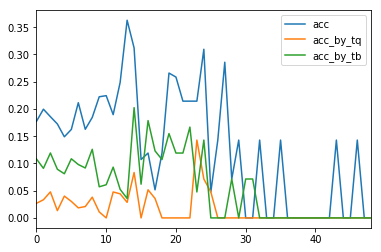

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", TIME_STEPS)
merged_metrics = np.zeros((TIME_STEPS,4))
for i in range(TIME_STEPS) :
    merged_metrics[i,:] = [metrics["acc"+str(i)],metrics["sc"+str(i)],metrics["acc_by_tq"+str(i)],metrics["acc_by_tb"+str(i)]]

plt.figure()
avg_metrics_df = pd.DataFrame(merged_metrics, columns=["acc","sc","acc_by_tq","acc_by_tb"])
avg_metrics_df["acc"].plot()
avg_metrics_df["acc_by_tq"].plot()
avg_metrics_df["acc_by_tb"].plot()
plt.legend()
display(avg_metrics_df)

Model artifacts were created as part of the training. You can run the following to get a Tensorboard visualization of our data model.

You will need to modify SAVE_FILENAME to the name of a checkpoint file that was produced in your training run. Refer to the output of your local training job.

In [44]:
from __future__ import print_function
from io import BytesIO
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

SAVE_FILENAME = "model.ckpt-4200"

# Helper functions for TF Graph visualization
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

tf.reset_default_graph()

with tf.Session() as sess:
    
    metadata_file = SAVE_PATH+SAVE_FILENAME+".meta"
    saver = tf.train.import_meta_graph(metadata_file)    
    restore_path = SAVE_PATH
    saver.restore(sess, tf.train.latest_checkpoint(restore_path))  

    show_graph(tf.get_default_graph())

INFO:tensorflow:Restoring parameters from ./rnn_purchase_predictor/model.ckpt-4200


INFO:tensorflow:Restoring parameters from ./rnn_purchase_predictor/model.ckpt-4200


Great! Now we're ready to try remote training. We simply need to create a Sagemaker Tensorflow object and run the fit method:

In [ ]:
hyperparameters = {
    "MAX_TIMESTEP" : TIME_STEPS,
    "INPUT_SIZE" : INPUT_SIZE,
    "OUTPUT_SIZE" : OUTPUT_SIZE,
    "BATCH_SIZE" : BATCH_SIZE,
    "LSTM_UNITS" : LSTM_UNITS,
    "MAX_EPOCHS" : EPOCHS,
    "POSITIVE_THRESHOLD" : POSITIVE_THRESHOLD,
    "LEARNING_RATE" : LEARNING_RATE,
    "DROPOUT_RNN_STATE_KEEP_PROB" : DROPOUT_RNN_STATE_KEEP_PROB,
    "DROPOUT_RNN_INPUT_KEEP_PROB" : DROPOUT_RNN_INPUT_KEEP_PROB,
    "TOP_PROD_BY_QTYBOUGHT" : TOP_PROD_BY_QTYBOUGHT,
    "TOP_PROD_BY_TIMESBOUGHT" : TOP_PROD_BY_TIMESBOUGHT,
    "K_PREDICTIONS" : K_PREDICTIONS,
    "L2_REG_DENSE" : L2_REG_DENSE
}

tf_estimator = TensorFlow(entry_point = "./"+CUSTOM_TF_MODEL_FILENAME, 
                            role = iamRole,
                            training_steps = training_steps, 
                            evaluation_steps = evaluation_steps,
                            train_instance_count = TRAINING_INSTANCE_COUNT, 
                            train_instance_type = TRAINING_INSTANCE_TYPE,
                            output_path = model_dir,
                            hyperparameters = hyperparameters,
                            code_location = code_dir)

tf_estimator.fit(training_dir)

INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-2019-02-10-22-55-00-815


2019-02-10 22:55:01 Starting - Starting the training job...
2019-02-10 22:55:03 Starting - Launching requested ML instances......
2019-02-10 22:56:05 Starting - Preparing the instances for training......
2019-02-10 22:57:23 Downloading - Downloading input data
2019-02-10 22:57:23 Training - Downloading the training image...
2019-02-10 22:57:56 Training - Training image download completed. Training in progress..
2019-02-10 22:57:57,059 INFO - root - running container entrypoint
2019-02-10 22:57:57,059 INFO - root - starting train task
2019-02-10 22:57:57,081 INFO - container_support.training - Training starting
2019-02-10 22:58:00,054 INFO - tf_container - ----------------------TF_CONFIG--------------------------
2019-02-10 22:58:00,054 INFO - tf_container - {"environment": "cloud", "cluster": {"master": ["algo-1:2222"]}, "task": {"index": 0, "type": "master"}}
2019-02-10 22:58:00,054 INFO - tf_container - ---------------------------------------------------------
2019-02-10 22:58:00,054

Training is complete! We can now deploy an endpoint for our model by simply calling the "deploy" method on our Sagemaker Tensorflow object. A RealTimePredictor object can then be created to handle the serialization and deserialization of request and responses from our newly created endpoint using protobuf encoded streams.

In [22]:
endpoint = tf_estimator.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge').endpoint
rnn_purchase_predictor = RealTimePredictor(endpoint=endpoint,
                              deserializer=tf_deserializer, 
                              serializer=tf_serializer,
                              content_type=CONTENT_TYPE_OCTET_STREAM)

Let's predict what is the most likely product that will be purchased next using our validation set as the input.

In [23]:
n_previous_purchases = range(10)
customer_ids= [i for i,v in enumerate(SL_val) if v in n_previous_purchases]

predictions = np.zeros((len(customer_ids),4))

i=0
for id in customer_ids:
    
    request = predict_pb2.PredictRequest()
    request.model_spec.name = "generic_model"
    request.model_spec.signature_name = DEFAULT_SERVING_SIGNATURE_DEF_KEY
    request.inputs['ph_inputs'].CopyFrom(tf.contrib.util.make_tensor_proto(X_val[id], shape=[1,49,3648]))
    request.inputs["ph_sequence_lengths"].CopyFrom(tf.contrib.util.make_tensor_proto(SL_val[id], shape=[1,])) 

    result = rnn_purchase_predictor.predict(request)

    predictions[i,:] = [id,
                        result.outputs["prod_indices"].int_val[0],
                        result.outputs["prod_indices"].int_val[1],
                        result.outputs["prod_indices"].int_val[2]]
    i=i+1

Let's plot the results:

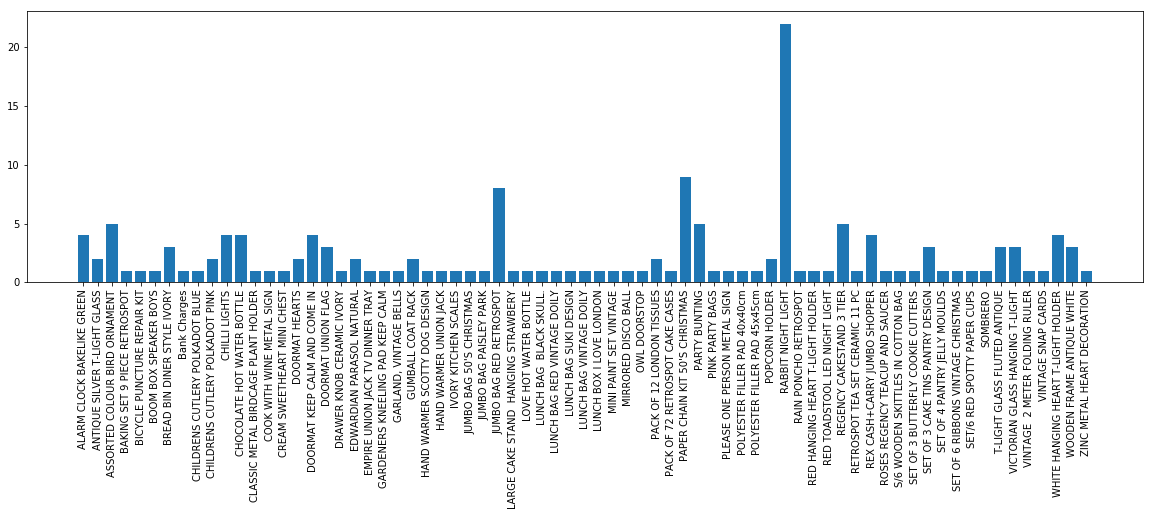

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

pred_df = pd.DataFrame(predictions,columns=["id","pred_1","pred_2","pred_3"])
#display(pred_df)
grouped = pred_df.groupby('pred_1')
pred_counts = grouped['pred_1'].agg(['count']).sort_values(by=['count'])
plot_data = pred_counts.join(products).sort_values(by="count")
#display(plot_data[["Description","count"]])

plt.figure(figsize=(20, 5))
plt.bar(plot_data["Description"],plot_data['count'])
plt.xticks(rotation='vertical')
plt.show()

If you download and deploy the model that I have provided <a href="https://github.com/aws-samples/aws-sagemaker-ml-blog-predictive-campaigns/blob/master/artifacts/models/model.tar.gz"> here</a>, you will see that the model predicts that a number of customers will buy the "Rabbit Night Light" next. Let's run a product promotion 


<img src="https://github.com/aws-samples/aws-sagemaker-ml-blog-predictive-campaigns/blob/master/artifacts/images/bunny_lamp.jpg?raw=true" height="35%" width="35%" /img>

Let's create a sample CSV file that can be imported into Amazon Pinpoint to run a campaign. Feel free to modify YOUR_EMAIL_ADDRESS so that you can send an email to yourself for testing.

PROMO_PRODUCT_ID has been set to 29 as it represents the product index for the "Rabbit Night Light."

In [26]:
YOUR_EMAIL_ADDRESS= "your@email.com"
N_CHANNEL_TYPES = 4
N_ATTR = 2
SMS, APNS, EMAIL, GCM = range(N_CHANNEL_TYPES)
PROMO_PRODUCT_ID = 29 #RABBIT_NIGHT_LIGHT
PLATFORMS = ['Android', 'IOS']
CHANNEL_TYPES = ['SMS', 'APNS','EMAIL','GCM']
cohort = []
for i in range(predictions.shape[0]) :

    if predictions[i,1] == PROMO_PRODUCT_ID :
        address = "customer"+str(int(predictions[i,0]))+"@amazon.com"
        cohort.append([CHANNEL_TYPES[EMAIL]] + 
                      predictions[i,0:2].astype(np.int32).tolist() + 
                      [address, PLATFORMS[np.random.randint(2)]])

cohort[0][3]= YOUR_EMAIL_ADDRESS      
cohort_df = pd.DataFrame(cohort, columns=["ChannelType","User.UserAttributes.Id","Attributes.Prediction_ProductID", "Address","Demographic.Platform"])
display(cohort_df)

,ChannelType,User.UserAttributes.Id,Attributes.Prediction_ProductID,Address,Demographic.Platform
0,EMAIL,1,29,your@email.com,Android
1,EMAIL,25,29,customer25@amazon.com,IOS
2,EMAIL,33,29,customer33@amazon.com,IOS
3,EMAIL,51,29,customer51@amazon.com,Android
4,EMAIL,53,29,customer53@amazon.com,IOS
5,EMAIL,66,29,customer66@amazon.com,Android
6,EMAIL,67,29,customer67@amazon.com,Android
7,EMAIL,76,29,customer76@amazon.com,IOS
8,EMAIL,78,29,customer78@amazon.com,IOS
9,EMAIL,84,29,customer84@amazon.com,Android


Now let's write this file out to S3, so that it can be imported into Amazon Pinpoint. Modify S3_BUCKET and the PINPOINT_ENDPOINT_DIR to where you want to write out this file.

In [47]:
S3_BUCKET = "awslabs-ml-samples"
PINPOINT_ENDPOINT_DIR = "pinpoint/endpoints/"
PINPOINT_ENDPOINT_DATA = "product_"+str(PROMO_PRODUCT_ID)+"_cohort.csv"
print("Amazon Pinpoint endpoint file name: "+PINPOINT_ENDPOINT_DATA)

Amazon Pinpoint endpoint file name: product_29_cohort.csv


Write out the file to S3. Note that you may need to replicate or move this file to us-east-1. At the time of writing, Amazon Pinpoint is only available in that region. Follow the steps outlined in my <a href="https://aws.amazon.com/blogs/machine-learning/amazon-pinpoint-campaigns-driven-by-machine-learning-on-amazon-sagemaker/"> blog </a> to get an idea of how you can run your "predictive" campaign from Amazon Pinpoint.

In [ ]:
s3_resource = boto3.resource('s3')

csv_buffer = cohort_df.to_csv(None, index=False).encode()
s3_object = s3_resource.Object(S3_BUCKET, PINPOINT_ENDPOINT_DIR+PINPOINT_ENDPOINT_DATA)
s3_object.put(Body=csv_buffer)